In [1]:
import pandas as pd
import numpy as np
import glob
import os
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Estimate daily concentrations of key chemical species

Aim: Derive daily time series of concentrations of the key variables of interest to the marine folk.

Time period of interest to be determined. Storm Hans is of particular interest, but we may be interested all the way back to 1990. **Discuss with Helene**

Do this using either:
1) Regressions with sensor data data (for 2023 only and Glomma only) (derived in notebook flux1_regressions), if regressions were meaningful
2) Regressions with discharge data (also derived in notebook flux1_regressions)
3) Interpolation of grab sample data if data frequency appears high enough
4) Filling using e.g. monthly median values if none of the above are appropriate

Output of this notebook is then used to estimate fluxes to the fjord.

In [2]:
river_names_mapper = {
    'Q_daily-mean_Drammenselva_Mjøndalen bru_12': 'discharge_Drammenselva v/Krokstadelva',
    'Q_daily-mean_Glomma_Solbergfoss_2': 'discharge_Glomma v/Sarpefossen',
    'Q_daily-mean_Numedalslågen_Holmfoss_15': 'discharge_Numedalslågen v/E18'
}

## Users Inputs

**Water Chemistry**

In [3]:
chem_df = pd.read_csv('../../data/river/water_chem/cleaned_niva/dremmen_glomma_numed_key_wc_species_cleaned.csv')
chem_df['sample_date'] = pd.to_datetime(chem_df['sample_date'])

variables = ['Farge_mg Pt/l', 'DIN_mg/l', 'PO4-P_µg/l', 'SiO2_mg/l', 'TOC_mg/l',
             'TOTN_µg/l', 'TOTP/F_µg/l P', 'TOTP_P_µg/l P', 'TSM_mg/l']
chem_df.head()

sample_date  station_id station_code                 station_name  \
0  1990-01-11       40352         DRA1  Drammenselva v/Krokstadelva   
1  1990-02-12       40352         DRA1  Drammenselva v/Krokstadelva   
2  1990-03-13       40352         DRA1  Drammenselva v/Krokstadelva   
3  1990-04-18       40352         DRA1  Drammenselva v/Krokstadelva   
4  1990-05-21       40352         DRA1  Drammenselva v/Krokstadelva   

   Farge_mg Pt/l  DIN_mg/l  PO4-P_µg/l  SiO2_mg/l  TOC_mg/l  TOTN_µg/l  \
0            NaN       NaN         0.5        NaN       NaN      350.0   
1            NaN       NaN         2.0        NaN       NaN      419.0   
2            NaN       NaN         1.5        NaN       NaN      405.0   
3            NaN       NaN         1.5        NaN       NaN      399.0   
4            NaN       NaN         0.5        NaN       NaN      317.0   

   TOTP/F_µg/l P  TOTP_P_µg/l P  TSM_mg/l  
0            NaN            NaN       0.8  
1            NaN            NaN       2.0  
2            NaN            NaN       1.4  
3            NaN            NaN       1.3  
4            NaN            NaN       1.7

**River Discharges**

In [4]:
q_directory = r'../../data/river/discharge/clean'

# Get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(q_directory, '*.csv'))

# Initialize an empty DataFrame to hold the combined data
discharge_df = pd.DataFrame()

# Loop through each file and process it
for file in csv_files:
    # Extract the river name from the file name
    river_name = os.path.basename(file).split('.')[0]
    
    # Read the CSV file
    df = pd.read_csv(file)
    
     # Select the Date and discharge columns, and rename the discharge column
    discharge_column = df[['Date', 'Discharge']].rename(columns={'Discharge': river_names_mapper[river_name]})
    
    # Merge the discharge columns on the Date column
    if discharge_df.empty:
        discharge_df = discharge_column
    else:
        discharge_df = pd.merge(discharge_df, discharge_column, on='Date', how='outer')


# Convert 'Date' to datetime format
discharge_df['Date'] = pd.to_datetime(discharge_df['Date'])

# Extract the year and add it as a new column
# discharge_df['year'] = discharge_df['Date'].dt.year

# discharge_df.set_index('Date', inplace=True)
discharge_df['Date'] = pd.to_datetime(discharge_df['Date'])
discharge_df.head()

Date  discharge_Glomma v/Sarpefossen  \
0 1990-01-01                           425.0   
1 1990-01-02                           500.0   
2 1990-01-03                           500.0   
3 1990-01-04                           500.0   
4 1990-01-05                           472.0   

   discharge_Drammenselva v/Krokstadelva  discharge_Numedalslågen v/E18  
0                                264.681                         75.875  
1                                264.681                         75.160  
2                                260.214                         73.044  
3                                260.214                         75.160  
4                                260.214                         81.769

**Water Chemistry and Discharges**

In [5]:
# Merge datasets on date to keep only the dates where chemistry data is available
discharge_long_df = discharge_df.melt(id_vars=['Date'], 
                                      var_name='station_name', 
                                      value_name='discharge')

discharge_long_df['station_name'] = discharge_long_df['station_name'].str.replace('discharge_', '')

discharge_long_df['Date'] = pd.to_datetime(discharge_long_df['Date'])

chem_df.reset_index(inplace=True)
chem_df['sample_date'] = chem_df['sample_date'].dt.date
chem_df.rename(columns={'sample_date': 'Date'}, inplace=True)
chem_df['Date'] = pd.to_datetime(chem_df['Date'])

merged_df = pd.merge(discharge_long_df, chem_df, on=['Date', 'station_name'], how='left')
merged_df.head()

Date          station_name  discharge  index  station_id station_code  \
0 1990-01-01  Glomma v/Sarpefossen      425.0    NaN         NaN          NaN   
1 1990-01-02  Glomma v/Sarpefossen      500.0    NaN         NaN          NaN   
2 1990-01-03  Glomma v/Sarpefossen      500.0    NaN         NaN          NaN   
3 1990-01-04  Glomma v/Sarpefossen      500.0    NaN         NaN          NaN   
4 1990-01-05  Glomma v/Sarpefossen      472.0    NaN         NaN          NaN   

   Farge_mg Pt/l  DIN_mg/l  PO4-P_µg/l  SiO2_mg/l  TOC_mg/l  TOTN_µg/l  \
0            NaN       NaN         NaN        NaN       NaN        NaN   
1            NaN       NaN         NaN        NaN       NaN        NaN   
2            NaN       NaN         NaN        NaN       NaN        NaN   
3            NaN       NaN         NaN        NaN       NaN        NaN   
4            NaN       NaN         NaN        NaN       NaN        NaN   

   TOTP/F_µg/l P  TOTP_P_µg/l P  TSM_mg/l  
0            NaN            NaN       NaN  
1            NaN            NaN       NaN  
2            NaN            NaN       NaN  
3            NaN            NaN       NaN  
4            NaN            NaN       NaN

**Sensor Data**

**Sensor and water chemistry**

To do...

## 1. Linear Interpolation

In [6]:
# Function to process each station
def process_station(station_df):
         
    # Drop duplicates
    station_df = station_df.drop_duplicates(subset='Date')
    
    # Create daily timestep
    station_df = station_df.set_index('Date').resample('D').asfreq()

    # Fill station_code and station_name
    station_df['station_id'] = station_df['station_id'].ffill().bfill()
    station_df['station_code'] = station_df['station_code'].ffill().bfill()
    station_df['station_name'] = station_df['station_name'].ffill().bfill()
    
    # Interpolate each variable
    for var in variables:
        last_valid_index = station_df[var].last_valid_index()
        if last_valid_index:
            station_df[var] = station_df[var].interpolate(method='linear').where(station_df.index <= last_valid_index)
    
    return station_df


# Apply the function to each station
df_interpolated = chem_df.groupby('station_id').apply(process_station).reset_index(level=0, drop=True)
df_interpolated.head(10)

/tmp/ipykernel_9992/2566507906.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_interpolated = chem_df.groupby('station_id').apply(process_station).reset_index(level=0, drop=True)


index  station_id station_code                 station_name  \
Date                                                                      
1990-01-11    0.0     40352.0         DRA1  Drammenselva v/Krokstadelva   
1990-01-12    NaN     40352.0         DRA1  Drammenselva v/Krokstadelva   
1990-01-13    NaN     40352.0         DRA1  Drammenselva v/Krokstadelva   
1990-01-14    NaN     40352.0         DRA1  Drammenselva v/Krokstadelva   
1990-01-15    NaN     40352.0         DRA1  Drammenselva v/Krokstadelva   
1990-01-16    NaN     40352.0         DRA1  Drammenselva v/Krokstadelva   
1990-01-17    NaN     40352.0         DRA1  Drammenselva v/Krokstadelva   
1990-01-18    NaN     40352.0         DRA1  Drammenselva v/Krokstadelva   
1990-01-19    NaN     40352.0         DRA1  Drammenselva v/Krokstadelva   
1990-01-20    NaN     40352.0         DRA1  Drammenselva v/Krokstadelva   

            Farge_mg Pt/l  DIN_mg/l  PO4-P_µg/l  SiO2_mg/l  TOC_mg/l  \
Date                                                                   
1990-01-11            NaN       NaN    0.500000        NaN       NaN   
1990-01-12            NaN       NaN    0.546875        NaN       NaN   
1990-01-13            NaN       NaN    0.593750        NaN       NaN   
1990-01-14            NaN       NaN    0.640625        NaN       NaN   
1990-01-15            NaN       NaN    0.687500        NaN       NaN   
1990-01-16            NaN       NaN    0.734375        NaN       NaN   
1990-01-17            NaN       NaN    0.781250        NaN       NaN   
1990-01-18            NaN       NaN    0.828125        NaN       NaN   
1990-01-19            NaN       NaN    0.875000        NaN       NaN   
1990-01-20            NaN       NaN    0.921875        NaN       NaN   

            TOTN_µg/l  TOTP/F_µg/l P  TOTP_P_µg/l P  TSM_mg/l  
Date                                                           
1990-01-11  350.00000            NaN            NaN    0.8000  
1990-01-12  352.15625            NaN            NaN    0.8375  
1990-01-13  354.31250            NaN            NaN    0.8750  
1990-01-14  356.46875            NaN            NaN    0.9125  
1990-01-15  358.62500            NaN            NaN    0.9500  
1990-01-16  360.78125            NaN            NaN    0.9875  
1990-01-17  362.93750            NaN            NaN    1.0250  
1990-01-18  365.09375            NaN            NaN    1.0625  
1990-01-19  367.25000            NaN            NaN    1.1000  
1990-01-20  369.40625            NaN            NaN    1.1375

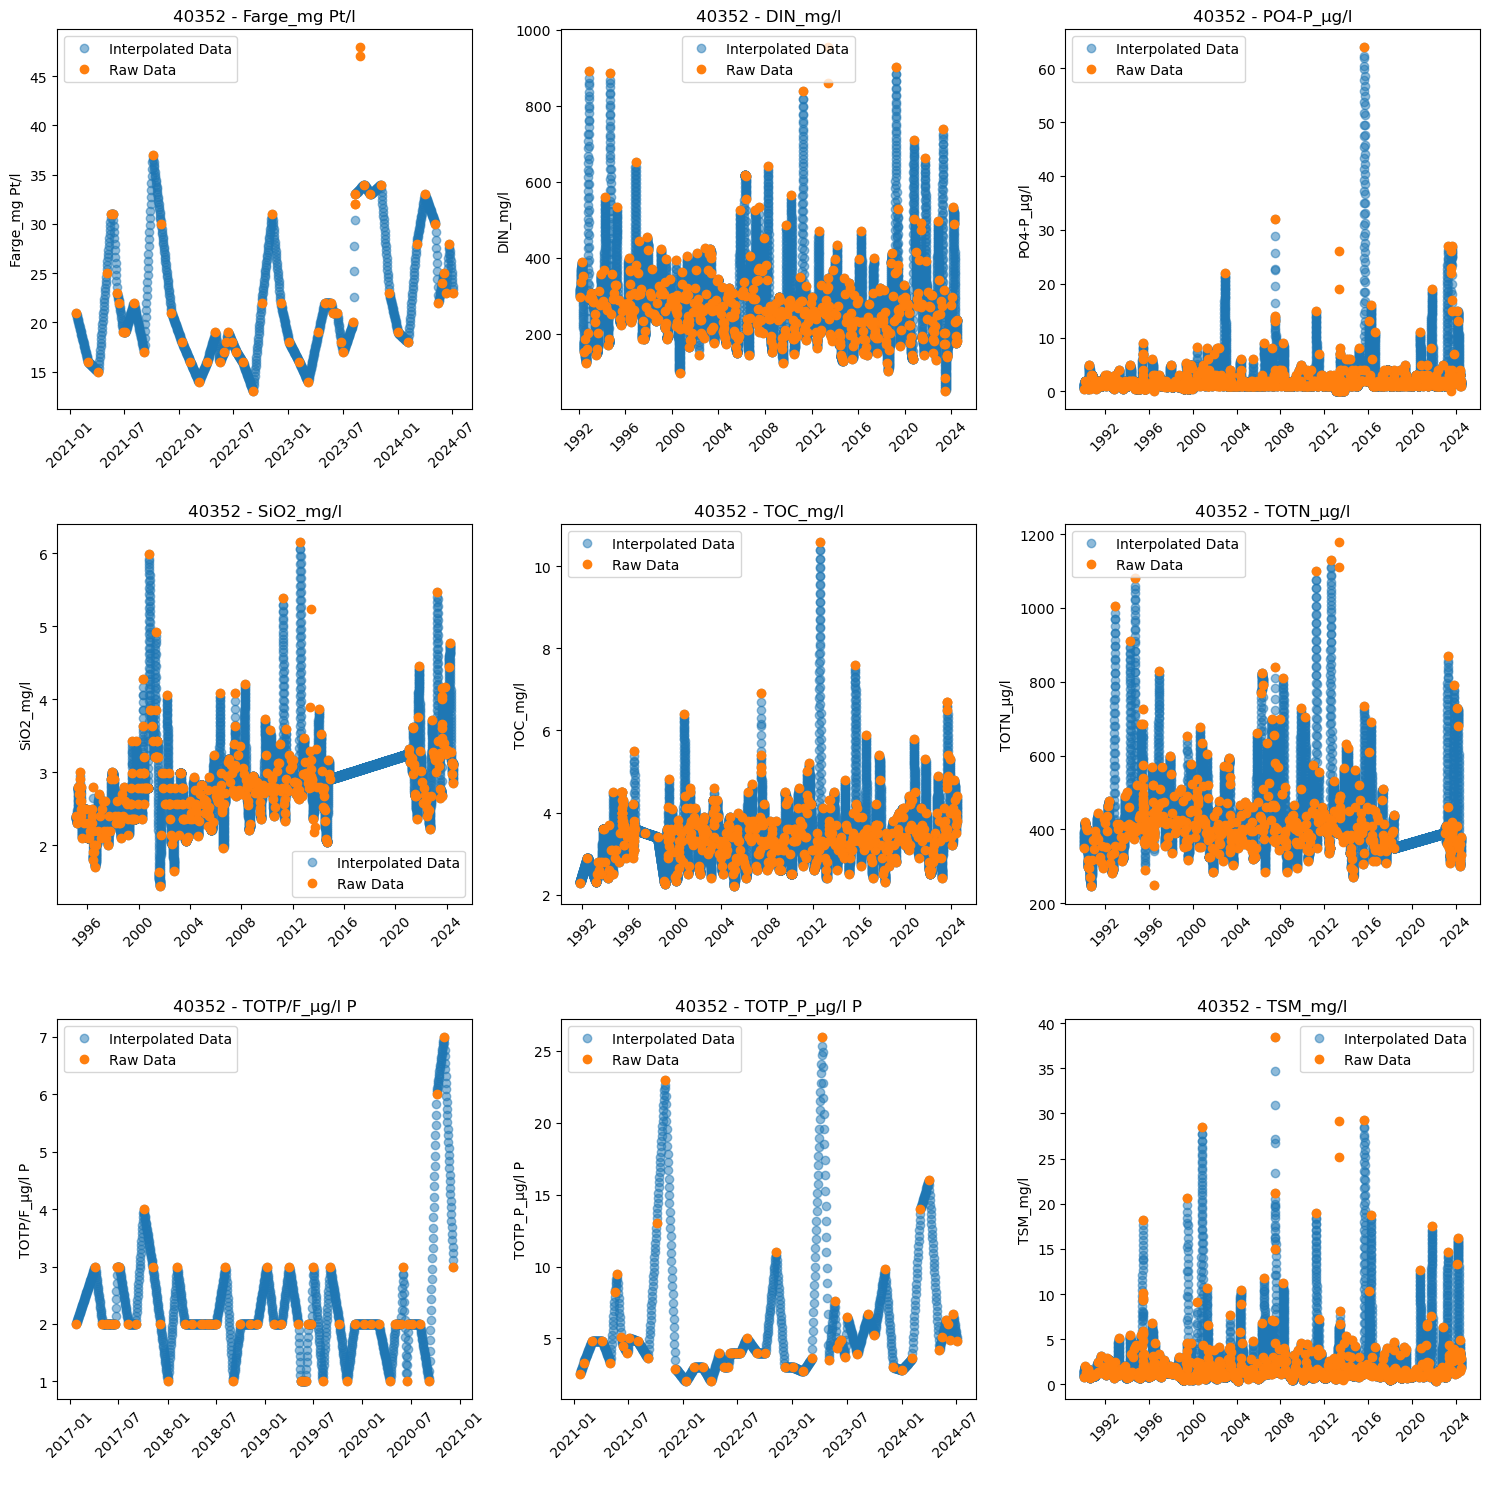

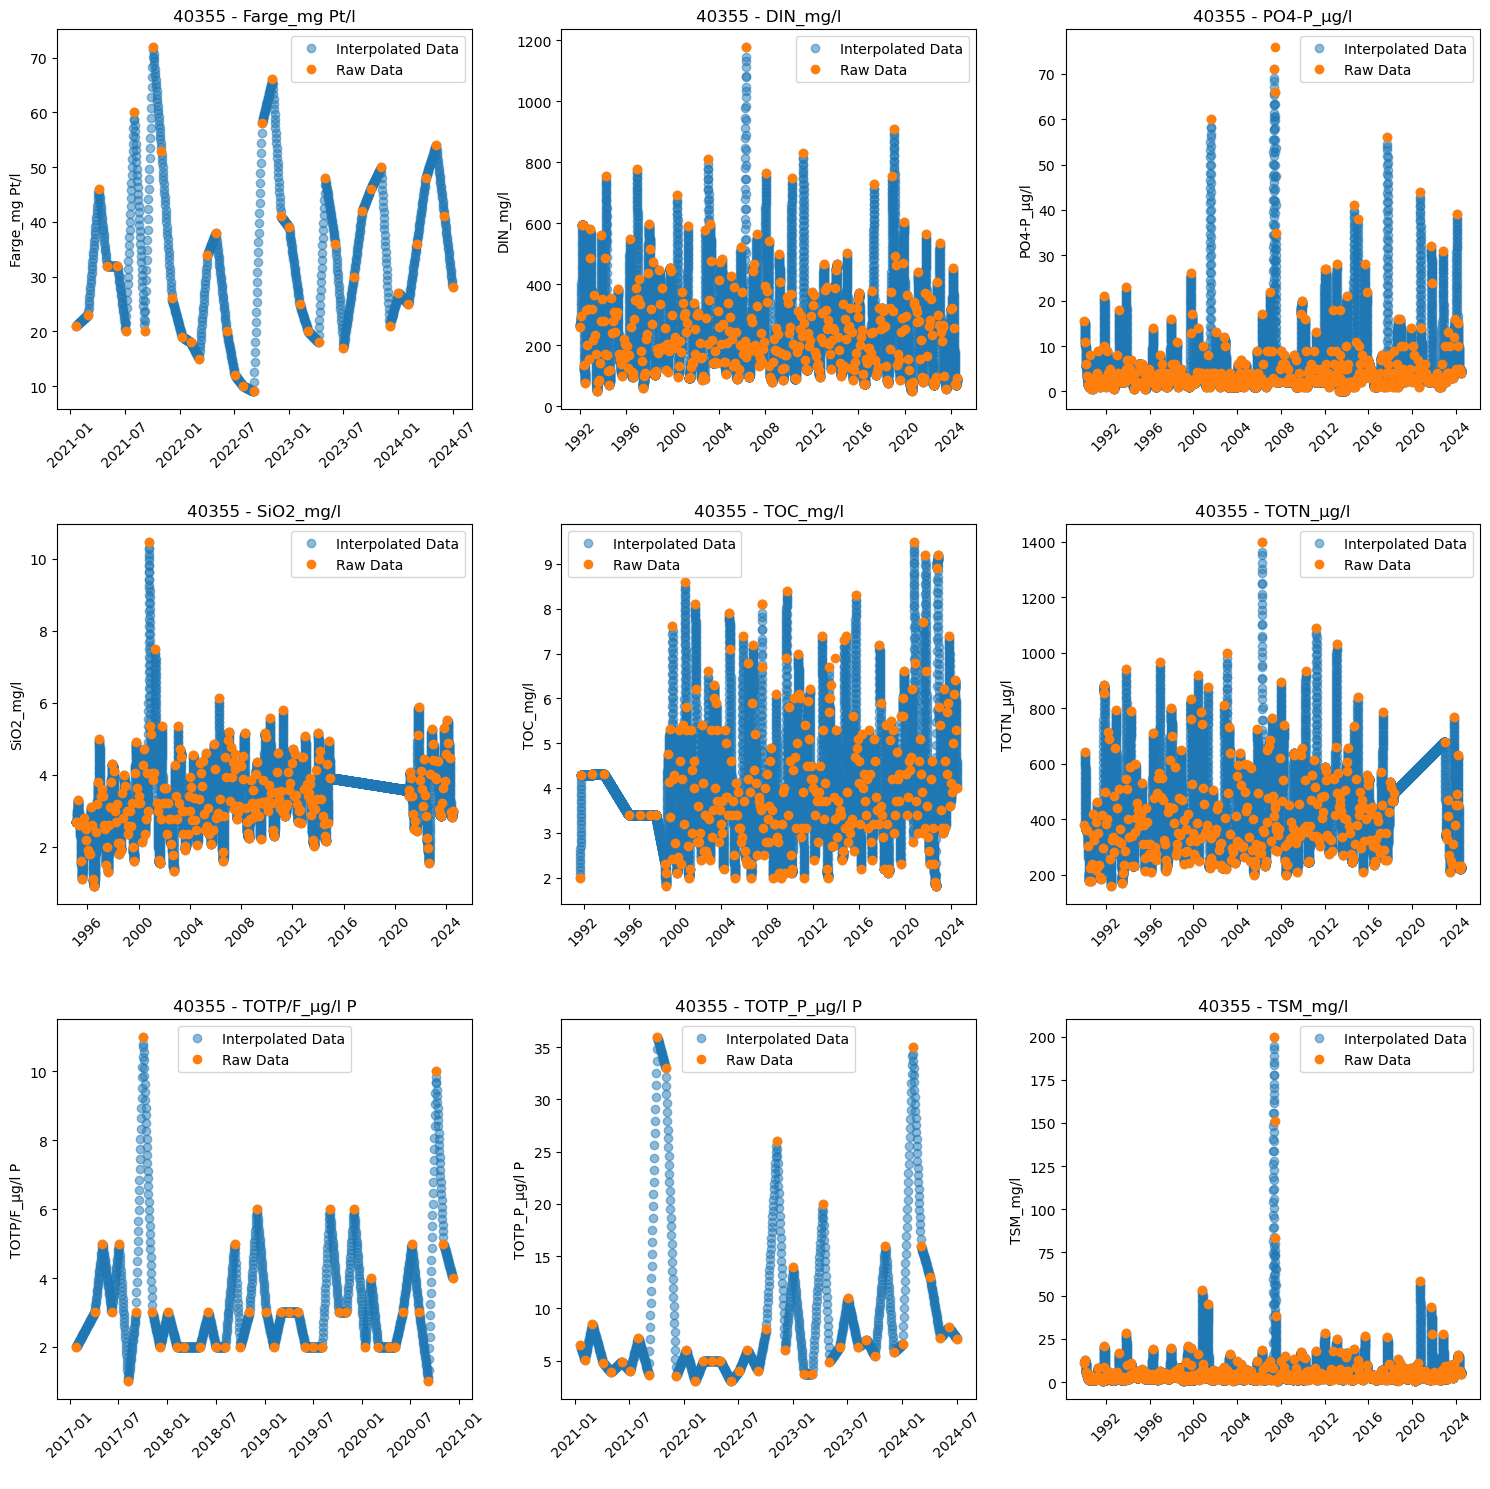

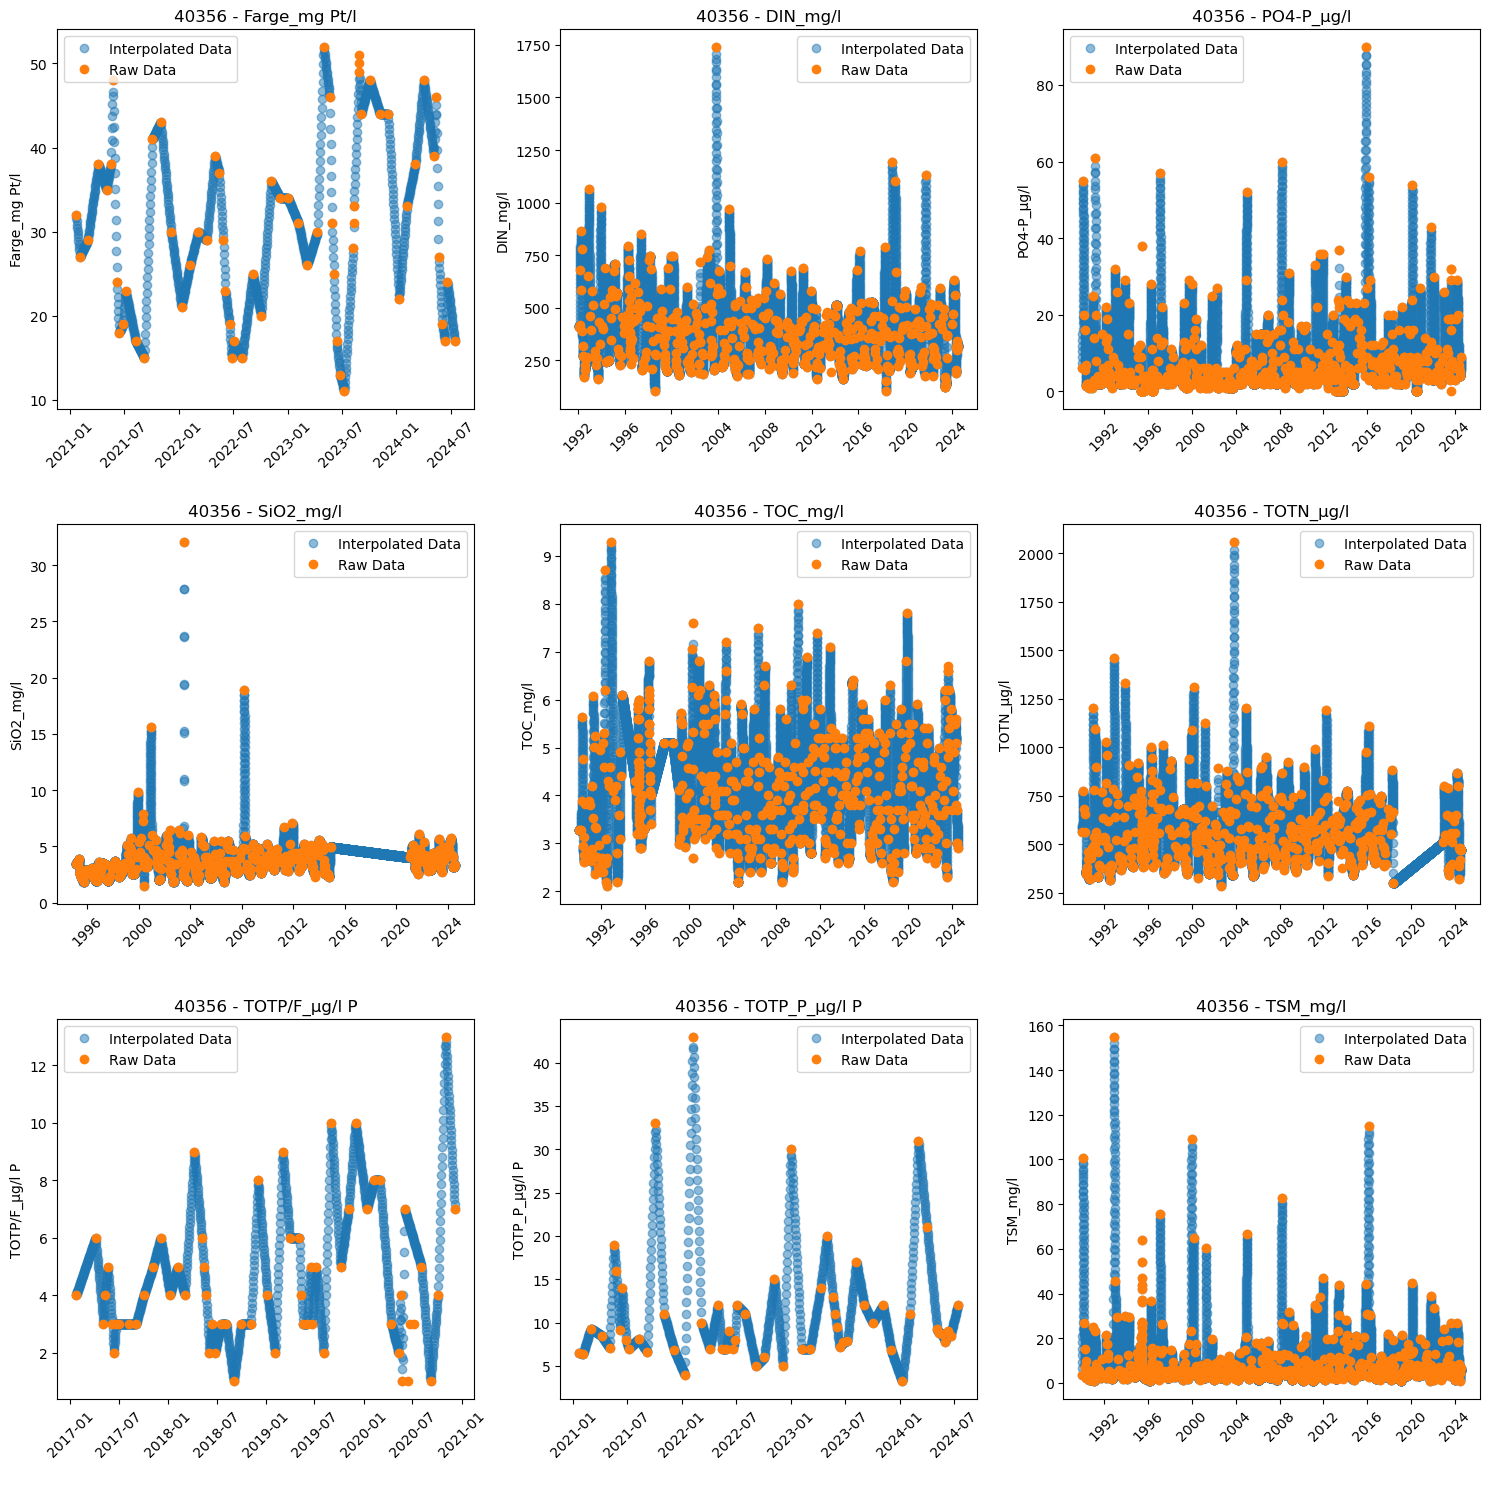

In [7]:
# Plotting
stations = chem_df['station_id'].unique()

for station in stations:
    raw_data = chem_df[chem_df['station_id'] == station].set_index('Date')
    interpolated_data = df_interpolated[df_interpolated['station_id'] == station]
    
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
    axes = axes.flatten()  # Flatten the 3x3 array of axes for easy iteration
    
    for i, var in enumerate(variables):
        if i < 9:  # Ensure we don't exceed the number of subplots
            ax = axes[i]
            ax.plot(interpolated_data.index, interpolated_data[var], 'o', label='Interpolated Data', alpha=0.5)
            ax.plot(raw_data.index, raw_data[var], 'o', label='Raw Data')
            ax.set_title(f'{station} - {var}')
            ax.set_xlabel(' ')
            ax.set_ylabel(var)
            ax.xaxis.set_tick_params(labelrotation=45)
            ax.legend()
    
    # Hide any unused subplots
    for j in range(i + 1, 9):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

## 3. Regressions with discharge data
Regressions with data that is available at daily frequency. I am using linear regression on log-transformed data and correct for back-transformation bias. This works better.


/tmp/ipykernel_9992/2903429537.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
/tmp/ipykernel_9992/2903429537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
 

Station: Glomma v/Sarpefossen, Variable: Farge_mg Pt/l
Mean Absolute Error (MAE) on log-transformed data: 0.1379344832698844
Mean Squared Error (MSE) on log-transformed data: 0.02685066408607225
R-squared (R²) on log-transformed data: 0.015317951311691114


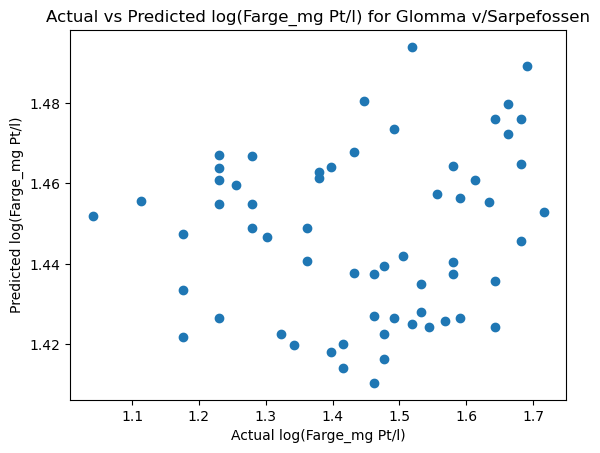

/tmp/ipykernel_9992/2903429537.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
/tmp/ipykernel_9992/2903429537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
 

Station: Glomma v/Sarpefossen, Variable: DIN_mg/l
Mean Absolute Error (MAE) on log-transformed data: 0.1266623431919928
Mean Squared Error (MSE) on log-transformed data: 0.02670061394146863
R-squared (R²) on log-transformed data: 0.1472926727307715


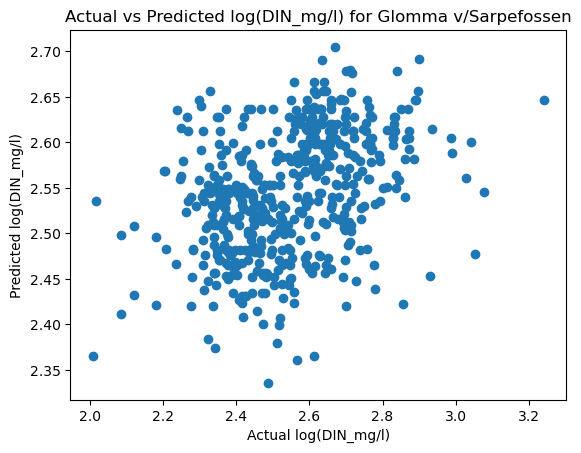

/tmp/ipykernel_9992/2903429537.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
/tmp/ipykernel_9992/2903429537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
 

Station: Glomma v/Sarpefossen, Variable: PO4-P_µg/l
Mean Absolute Error (MAE) on log-transformed data: 0.3537076352164966
Mean Squared Error (MSE) on log-transformed data: 0.18498886562840203
R-squared (R²) on log-transformed data: 0.01023572350877966


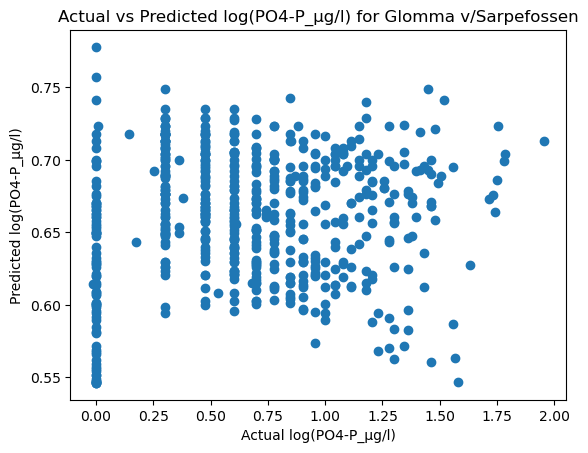

/tmp/ipykernel_9992/2903429537.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
/tmp/ipykernel_9992/2903429537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
 

Station: Glomma v/Sarpefossen, Variable: SiO2_mg/l
Mean Absolute Error (MAE) on log-transformed data: 0.1030883143010257
Mean Squared Error (MSE) on log-transformed data: 0.020035200205280518
R-squared (R²) on log-transformed data: 0.007289089596091314


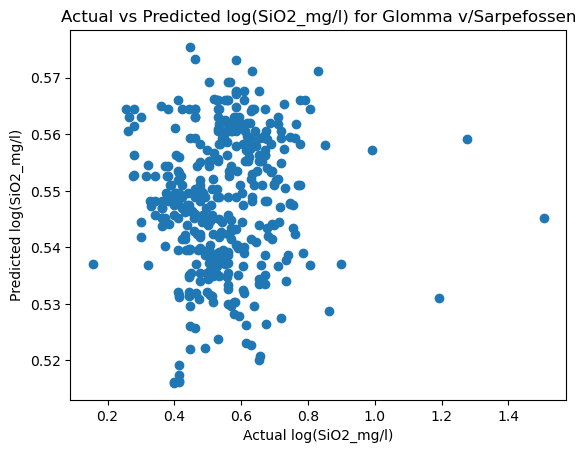

/tmp/ipykernel_9992/2903429537.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
/tmp/ipykernel_9992/2903429537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
 

Station: Glomma v/Sarpefossen, Variable: TOC_mg/l
Mean Absolute Error (MAE) on log-transformed data: 0.0959206981132914
Mean Squared Error (MSE) on log-transformed data: 0.013451892369871706
R-squared (R²) on log-transformed data: 0.08820320842382956


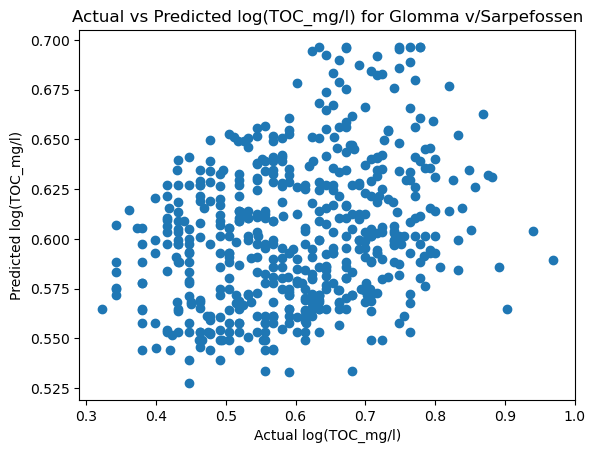

/tmp/ipykernel_9992/2903429537.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
/tmp/ipykernel_9992/2903429537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
 

Station: Glomma v/Sarpefossen, Variable: TOTN_µg/l
Mean Absolute Error (MAE) on log-transformed data: 0.09531689983432313
Mean Squared Error (MSE) on log-transformed data: 0.014427102701134946
R-squared (R²) on log-transformed data: 0.077380282778991


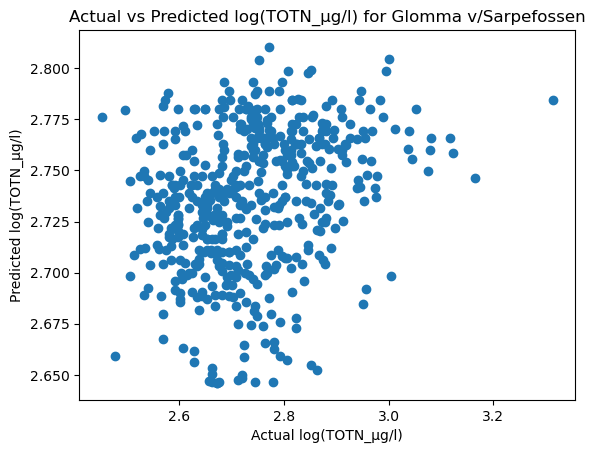

/tmp/ipykernel_9992/2903429537.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
/tmp/ipykernel_9992/2903429537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
 

Station: Glomma v/Sarpefossen, Variable: TOTP/F_µg/l P
Mean Absolute Error (MAE) on log-transformed data: 0.18814969588053773
Mean Squared Error (MSE) on log-transformed data: 0.05765516157786815
R-squared (R²) on log-transformed data: 0.008361206086744066


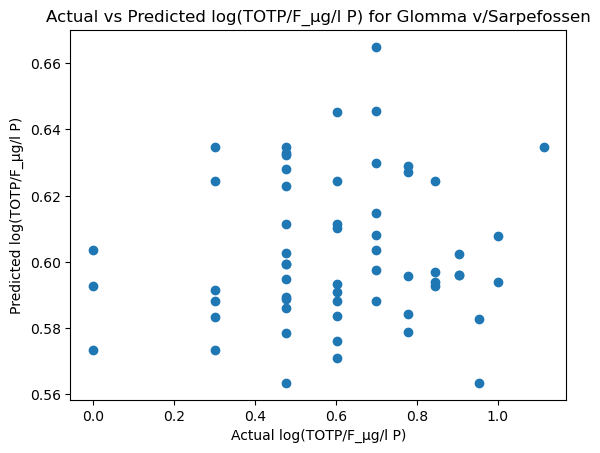

/tmp/ipykernel_9992/2903429537.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
/tmp/ipykernel_9992/2903429537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
 

Station: Glomma v/Sarpefossen, Variable: TOTP_P_µg/l P
Mean Absolute Error (MAE) on log-transformed data: 0.1539392480260054
Mean Squared Error (MSE) on log-transformed data: 0.04319411411590562
R-squared (R²) on log-transformed data: 0.06374459681085087


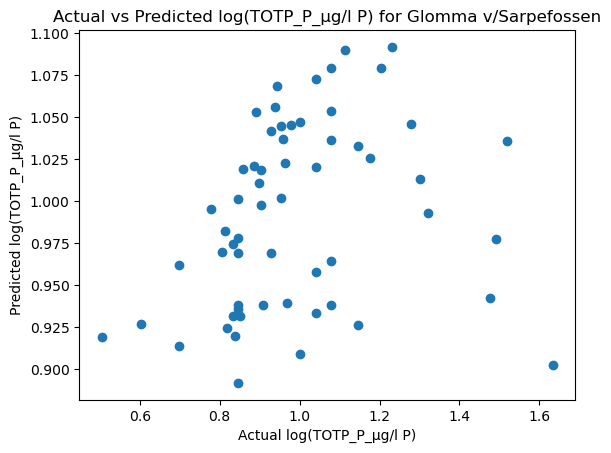

Station: Glomma v/Sarpefossen, Variable: TSM_mg/l
Mean Absolute Error (MAE) on log-transformed data: 0.27951774289280257
Mean Squared Error (MSE) on log-transformed data: 0.13239485807329537
R-squared (R²) on log-transformed data: 0.1283329930399606


/tmp/ipykernel_9992/2903429537.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
/tmp/ipykernel_9992/2903429537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
 

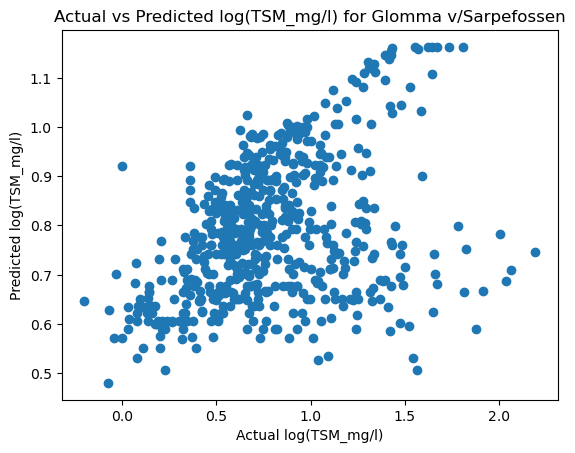

Station: Drammenselva v/Krokstadelva, Variable: Farge_mg Pt/l
Mean Absolute Error (MAE) on log-transformed data: 0.06226325066168379
Mean Squared Error (MSE) on log-transformed data: 0.0066536321328950895
R-squared (R²) on log-transformed data: 0.4645919820124361


/tmp/ipykernel_9992/2903429537.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
/tmp/ipykernel_9992/2903429537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
 

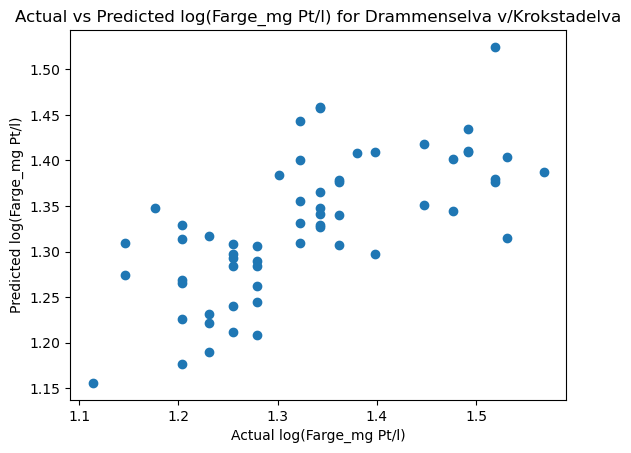

/tmp/ipykernel_9992/2903429537.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
/tmp/ipykernel_9992/2903429537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
 

Station: Drammenselva v/Krokstadelva, Variable: DIN_mg/l
Mean Absolute Error (MAE) on log-transformed data: 0.1087582024397323
Mean Squared Error (MSE) on log-transformed data: 0.02162402006767581
R-squared (R²) on log-transformed data: 0.020154511620155913


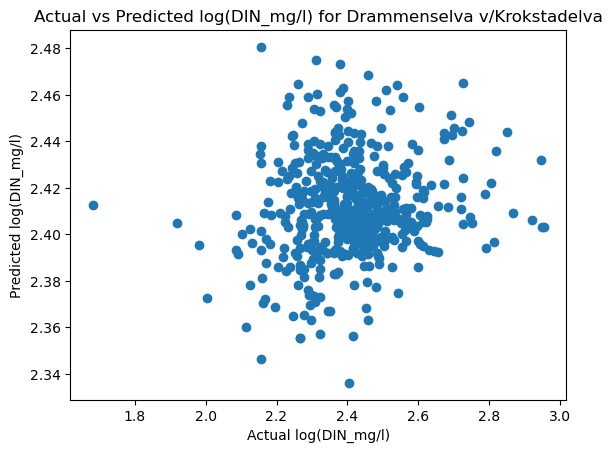

/tmp/ipykernel_9992/2903429537.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
/tmp/ipykernel_9992/2903429537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
 

Station: Drammenselva v/Krokstadelva, Variable: PO4-P_µg/l
Mean Absolute Error (MAE) on log-transformed data: 0.2257244907438927
Mean Squared Error (MSE) on log-transformed data: 0.08558299994550068
R-squared (R²) on log-transformed data: 0.17959875877891762


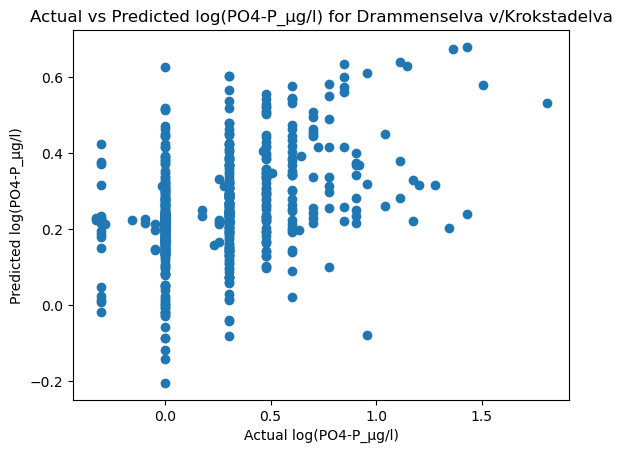

/tmp/ipykernel_9992/2903429537.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
/tmp/ipykernel_9992/2903429537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
 

Station: Drammenselva v/Krokstadelva, Variable: SiO2_mg/l
Mean Absolute Error (MAE) on log-transformed data: 0.052823201222170116
Mean Squared Error (MSE) on log-transformed data: 0.0052552260056068275
R-squared (R²) on log-transformed data: 0.19275134243756942


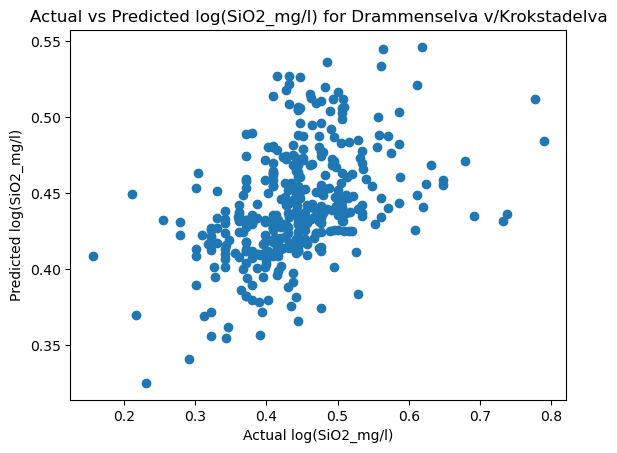

/tmp/ipykernel_9992/2903429537.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
/tmp/ipykernel_9992/2903429537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
 

Station: Drammenselva v/Krokstadelva, Variable: TOC_mg/l
Mean Absolute Error (MAE) on log-transformed data: 0.05607562982174454
Mean Squared Error (MSE) on log-transformed data: 0.005465715337238797
R-squared (R²) on log-transformed data: 0.20101034932271244


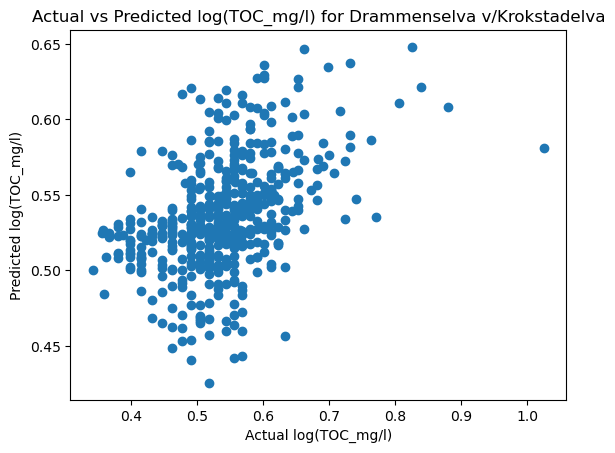

/tmp/ipykernel_9992/2903429537.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
/tmp/ipykernel_9992/2903429537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
 

Station: Drammenselva v/Krokstadelva, Variable: TOTN_µg/l
Mean Absolute Error (MAE) on log-transformed data: 0.06758079903473452
Mean Squared Error (MSE) on log-transformed data: 0.008970927693238042
R-squared (R²) on log-transformed data: 0.03499160675223956


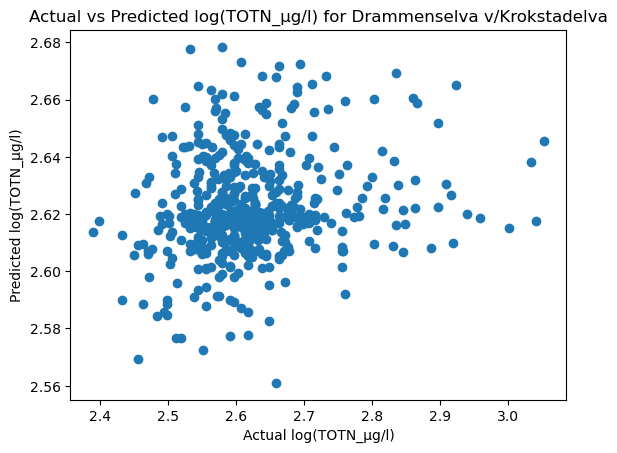

/tmp/ipykernel_9992/2903429537.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
/tmp/ipykernel_9992/2903429537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
 

Station: Drammenselva v/Krokstadelva, Variable: TOTP/F_µg/l P
Mean Absolute Error (MAE) on log-transformed data: 0.1144632631314027
Mean Squared Error (MSE) on log-transformed data: 0.029565924615054816
R-squared (R²) on log-transformed data: 0.029932084726936647


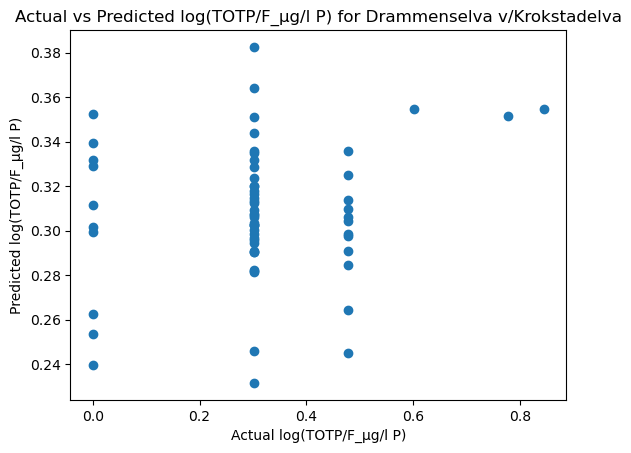

/tmp/ipykernel_9992/2903429537.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
/tmp/ipykernel_9992/2903429537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
 

Station: Drammenselva v/Krokstadelva, Variable: TOTP_P_µg/l P
Mean Absolute Error (MAE) on log-transformed data: 0.15239372917145413
Mean Squared Error (MSE) on log-transformed data: 0.04544741203556034
R-squared (R²) on log-transformed data: 0.16053022864585298


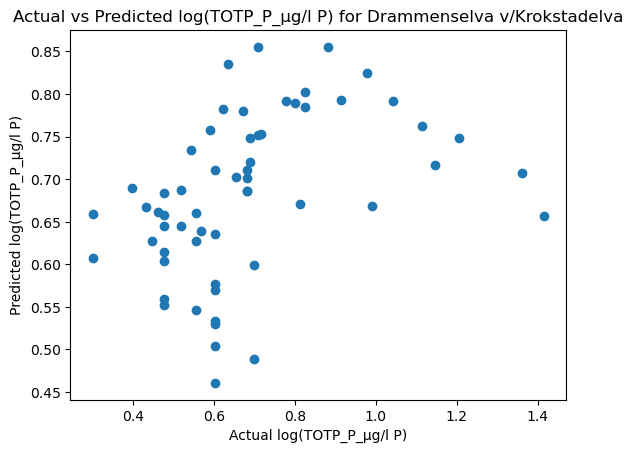

/tmp/ipykernel_9992/2903429537.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
/tmp/ipykernel_9992/2903429537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
 

Station: Drammenselva v/Krokstadelva, Variable: TSM_mg/l
Mean Absolute Error (MAE) on log-transformed data: 0.20619048130197182
Mean Squared Error (MSE) on log-transformed data: 0.07423660839906422
R-squared (R²) on log-transformed data: 0.26382773229668177


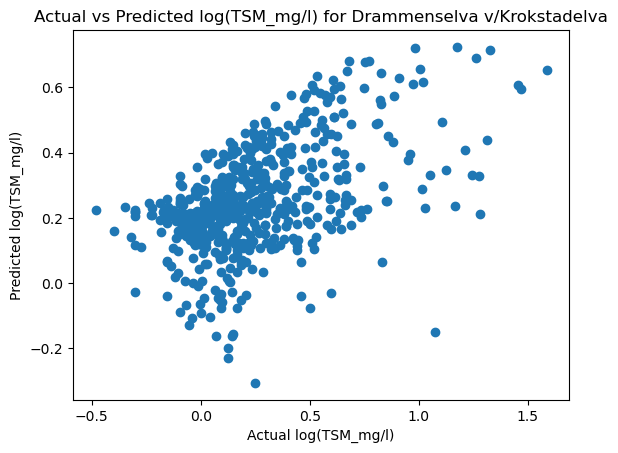

/tmp/ipykernel_9992/2903429537.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
/tmp/ipykernel_9992/2903429537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
 

Station: Numedalslågen v/E18, Variable: Farge_mg Pt/l
Mean Absolute Error (MAE) on log-transformed data: 0.11798113278866888
Mean Squared Error (MSE) on log-transformed data: 0.023032244787453287
R-squared (R²) on log-transformed data: 0.5192452064932129


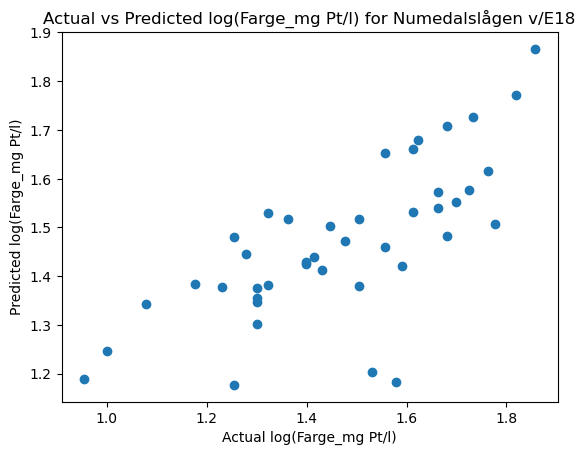

/tmp/ipykernel_9992/2903429537.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
/tmp/ipykernel_9992/2903429537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
 

Station: Numedalslågen v/E18, Variable: DIN_mg/l
Mean Absolute Error (MAE) on log-transformed data: 0.20872410687684814
Mean Squared Error (MSE) on log-transformed data: 0.0654647189988824
R-squared (R²) on log-transformed data: 0.00031616848026316813


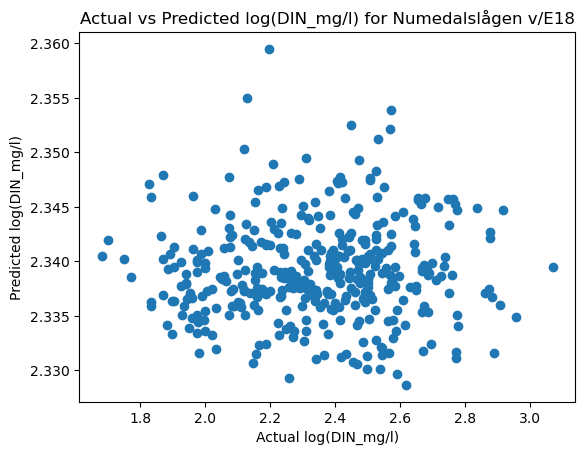

/tmp/ipykernel_9992/2903429537.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
/tmp/ipykernel_9992/2903429537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
 

Station: Numedalslågen v/E18, Variable: PO4-P_µg/l
Mean Absolute Error (MAE) on log-transformed data: 0.29157788436193266
Mean Squared Error (MSE) on log-transformed data: 0.13582868354449917
R-squared (R²) on log-transformed data: 0.1518556021150801


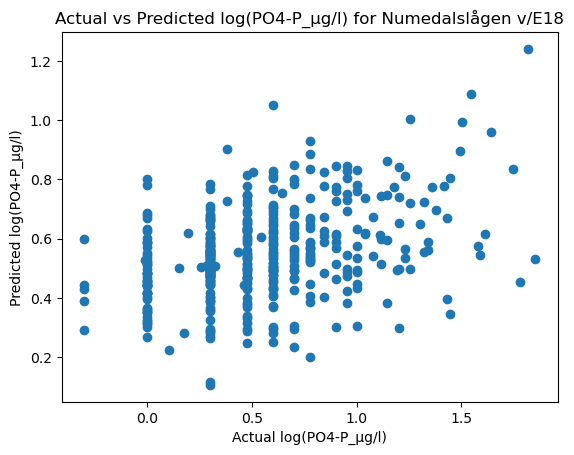

Station: Numedalslågen v/E18, Variable: SiO2_mg/l
Mean Absolute Error (MAE) on log-transformed data: 0.10701966601999581
Mean Squared Error (MSE) on log-transformed data: 0.018024591935658134
R-squared (R²) on log-transformed data: 0.1398413028556197


/tmp/ipykernel_9992/2903429537.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
/tmp/ipykernel_9992/2903429537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
 

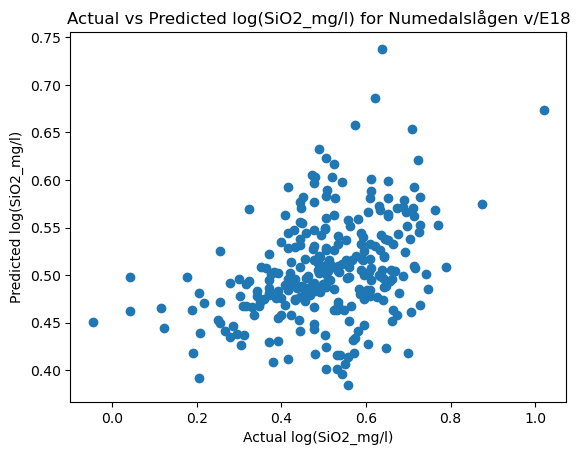

Station: Numedalslågen v/E18, Variable: TOC_mg/l
Mean Absolute Error (MAE) on log-transformed data: 0.09732621701505992
Mean Squared Error (MSE) on log-transformed data: 0.015555324342301398
R-squared (R²) on log-transformed data: 0.3904660715448547


/tmp/ipykernel_9992/2903429537.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
/tmp/ipykernel_9992/2903429537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
 

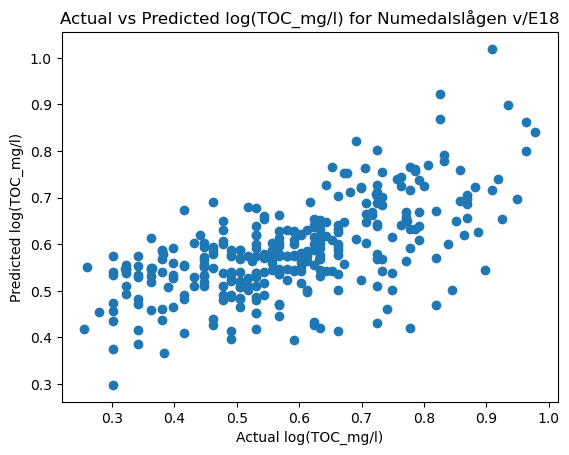

/tmp/ipykernel_9992/2903429537.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
/tmp/ipykernel_9992/2903429537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
 

Station: Numedalslågen v/E18, Variable: TOTN_µg/l
Mean Absolute Error (MAE) on log-transformed data: 0.13738733368595477
Mean Squared Error (MSE) on log-transformed data: 0.028532071460146042
R-squared (R²) on log-transformed data: 0.010044597618073303


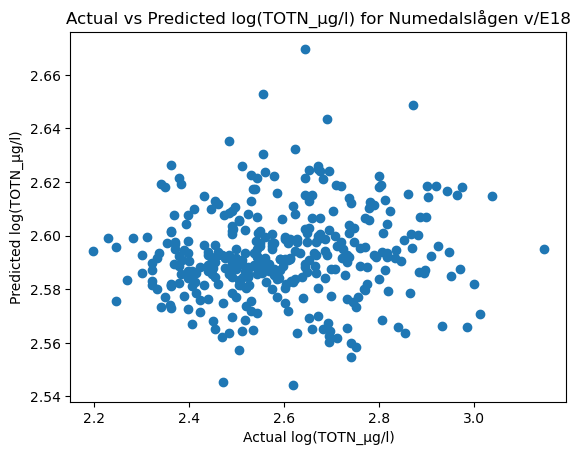

/tmp/ipykernel_9992/2903429537.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
/tmp/ipykernel_9992/2903429537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
 

Station: Numedalslågen v/E18, Variable: TOTP/F_µg/l P
Mean Absolute Error (MAE) on log-transformed data: 0.15407749778310573
Mean Squared Error (MSE) on log-transformed data: 0.03836981603613072
R-squared (R²) on log-transformed data: 0.17323100204432962


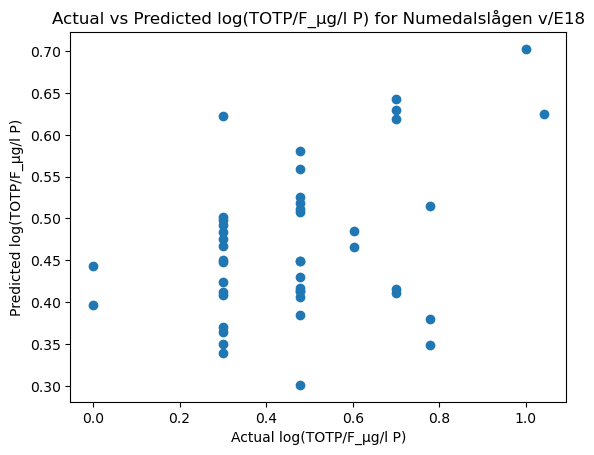

Station: Numedalslågen v/E18, Variable: TOTP_P_µg/l P
Mean Absolute Error (MAE) on log-transformed data: 0.18008645423110983
Mean Squared Error (MSE) on log-transformed data: 0.053882666009523086
R-squared (R²) on log-transformed data: 0.3357992764195853


/tmp/ipykernel_9992/2903429537.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
/tmp/ipykernel_9992/2903429537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
 

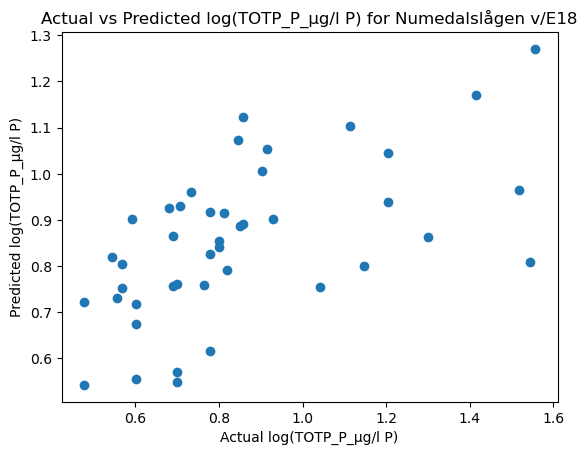

/tmp/ipykernel_9992/2903429537.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
/tmp/ipykernel_9992/2903429537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
 

Station: Numedalslågen v/E18, Variable: TSM_mg/l
Mean Absolute Error (MAE) on log-transformed data: 0.2600810450972291
Mean Squared Error (MSE) on log-transformed data: 0.10808223060871841
R-squared (R²) on log-transformed data: 0.3069598565553492


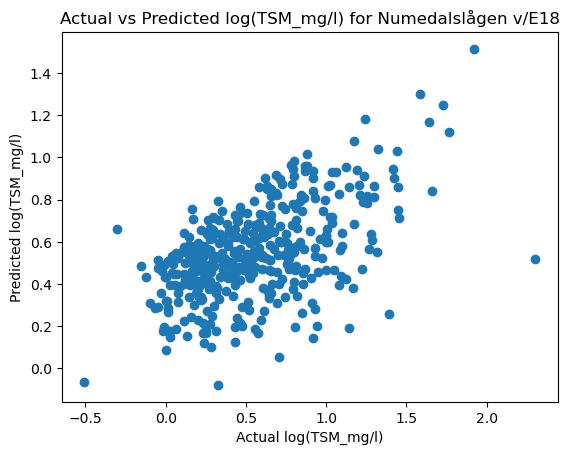

In [9]:
# Process each station and variable separately
stations = merged_df['station_name'].unique()

for station in stations:
    station_df = merged_df[merged_df['station_name'] == station].copy()
    
    # Remove duplicates, keeping only the first occurrence for each date and station_name combination
    station_df.drop_duplicates(subset=['Date', 'station_name'], keep='first', inplace=True)
    
    for var in variables:
        if var in station_df.columns:
            # Separate the data into two variables: the current variable and discharge
            y = station_df[var]
            X = station_df[['discharge']]
            
            # Identify the rows with missing values for the current variable
            missing_indices = y[y.isna()].index
            
            # Prepare the data for linear regression
            train_df = station_df.dropna(subset=[var])
            
            # Apply log base 10 transformation to the data, handling divide by zero by replacing zeros with a small value
            train_df.loc[:, f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
            train_df.loc[:, 'log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
            
            # Train the linear regression model on log-transformed data
            X_train_log = train_df[['log_discharge']]
            y_train_log = train_df[f'log_{var}']
            model_log = LinearRegression()
            model_log.fit(X_train_log, y_train_log)
            
            # Predict the missing values using the trained model on log-transformed data
            X_missing_log = np.log10(station_df.loc[missing_indices, 'discharge'].replace(0, np.nan)).fillna(0).values.reshape(-1, 1)
            if len(X_missing_log) > 0:  # Ensure there are missing values to predict
                predicted_log_toc = model_log.predict(X_missing_log)
                
                # Convert predictions back to original scale
                predicted_toc = np.power(10, predicted_log_toc)
                
                # Add the new predicted timeseries to the filtered dataframe in a separate column
                station_df.loc[missing_indices, f'{var}_predicted'] = predicted_toc
            
            # Evaluate the model on log-transformed data
            y_train_pred_log = model_log.predict(X_train_log)
            
            mae_log = mean_absolute_error(y_train_log, y_train_pred_log)
            mse_log = mean_squared_error(y_train_log, y_train_pred_log)
            r2_log = r2_score(y_train_log, y_train_pred_log)
            
            print(f'Station: {station}, Variable: {var}')
            print(f'Mean Absolute Error (MAE) on log-transformed data: {mae_log}')
            print(f'Mean Squared Error (MSE) on log-transformed data: {mse_log}')
            print(f'R-squared (R²) on log-transformed data: {r2_log}')
            
            # Visualize the results on log-transformed data
            plt.scatter(y_train_log, y_train_pred_log)
            plt.xlabel(f'Actual log({var})')
            plt.ylabel(f'Predicted log({var})')
            plt.title(f'Actual vs Predicted log({var}) for {station}')
            plt.show()

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Station: Glomma v/Sarpefossen, Variable: Farge_mg Pt/l
Mean Absolute Error (MAE) on log-transformed data: 0.1379344832698844
Mean Squared Error (MSE) on log-transformed data: 0.02685066408607225
R-squared (R²) on log-transformed data: 0.015317951311691114


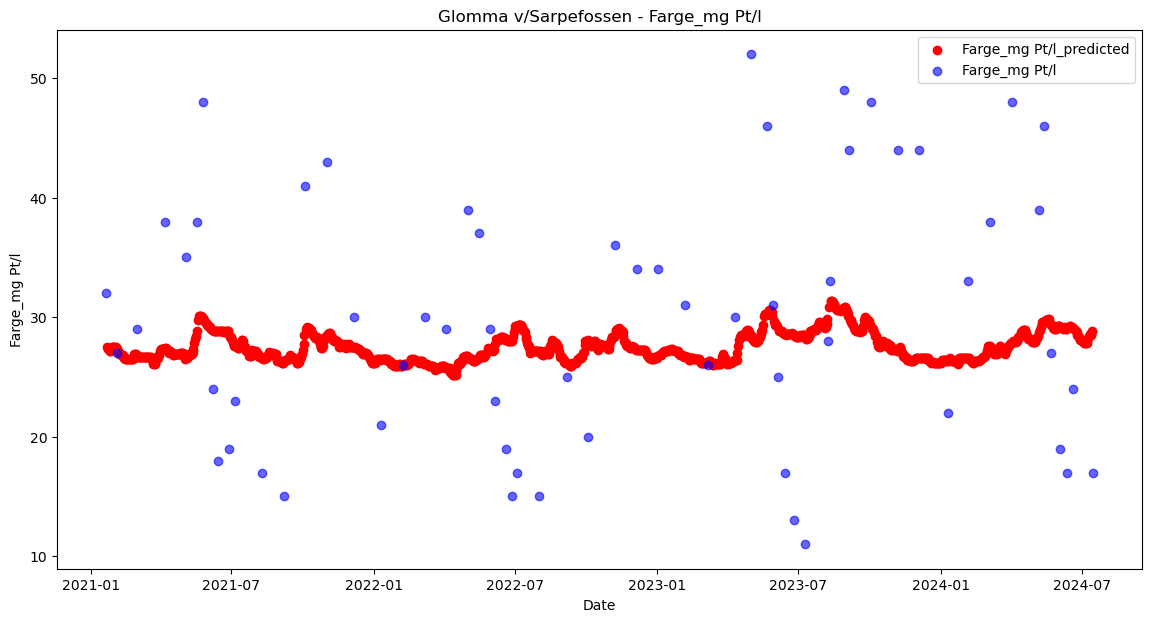

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Station: Glomma v/Sarpefossen, Variable: DIN_mg/l
Mean Absolute Error (MAE) on log-transformed data: 0.1266623431919928
Mean Squared Error (MSE) on log-transformed data: 0.02670061394146863
R-squared (R²) on log-transformed data: 0.1472926727307715


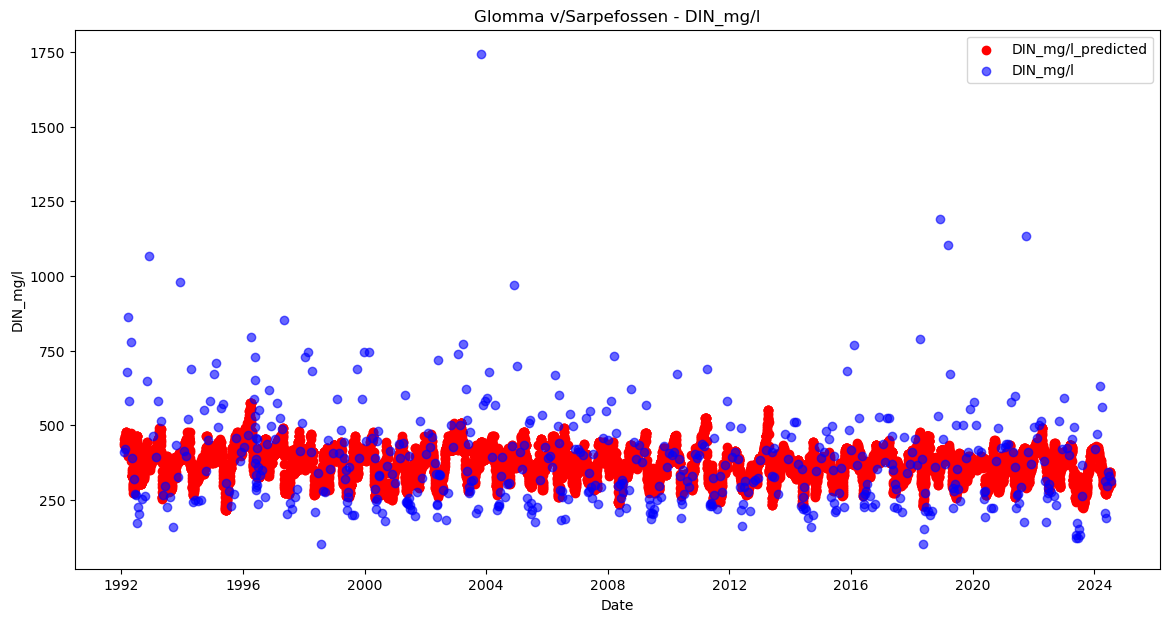

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Station: Glomma v/Sarpefossen, Variable: PO4-P_µg/l
Mean Absolute Error (MAE) on log-transformed data: 0.3537076352164966
Mean Squared Error (MSE) on log-transformed data: 0.18498886562840203
R-squared (R²) on log-transformed data: 0.01023572350877966


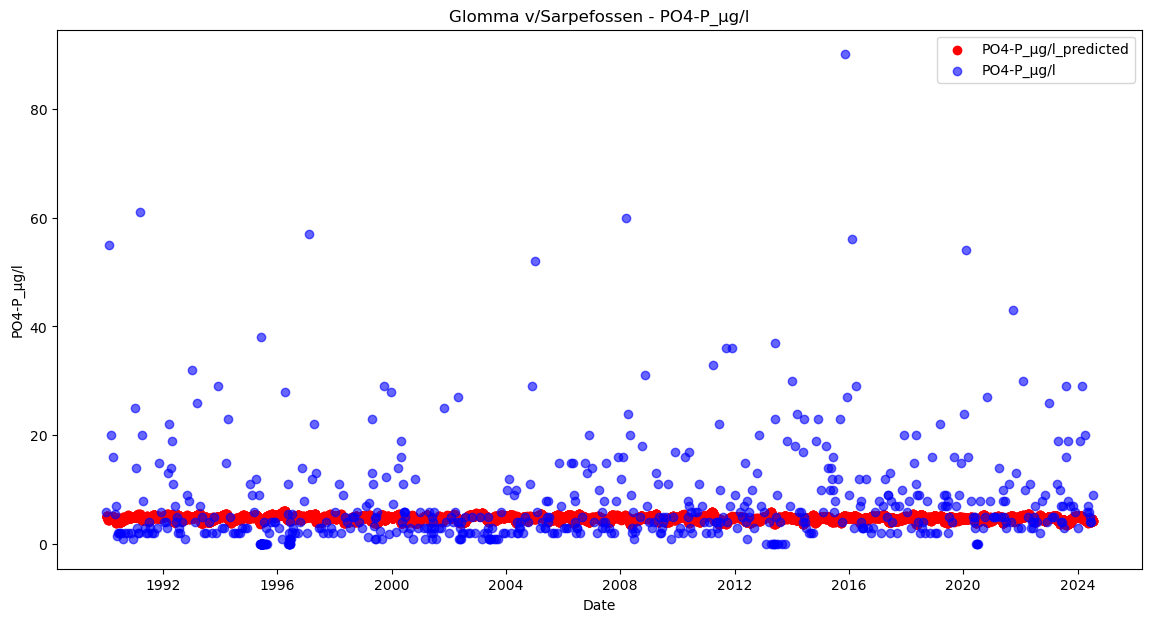

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Station: Glomma v/Sarpefossen, Variable: SiO2_mg/l
Mean Absolute Error (MAE) on log-transformed data: 0.1030883143010257
Mean Squared Error (MSE) on log-transformed data: 0.020035200205280518
R-squared (R²) on log-transformed data: 0.007289089596091314


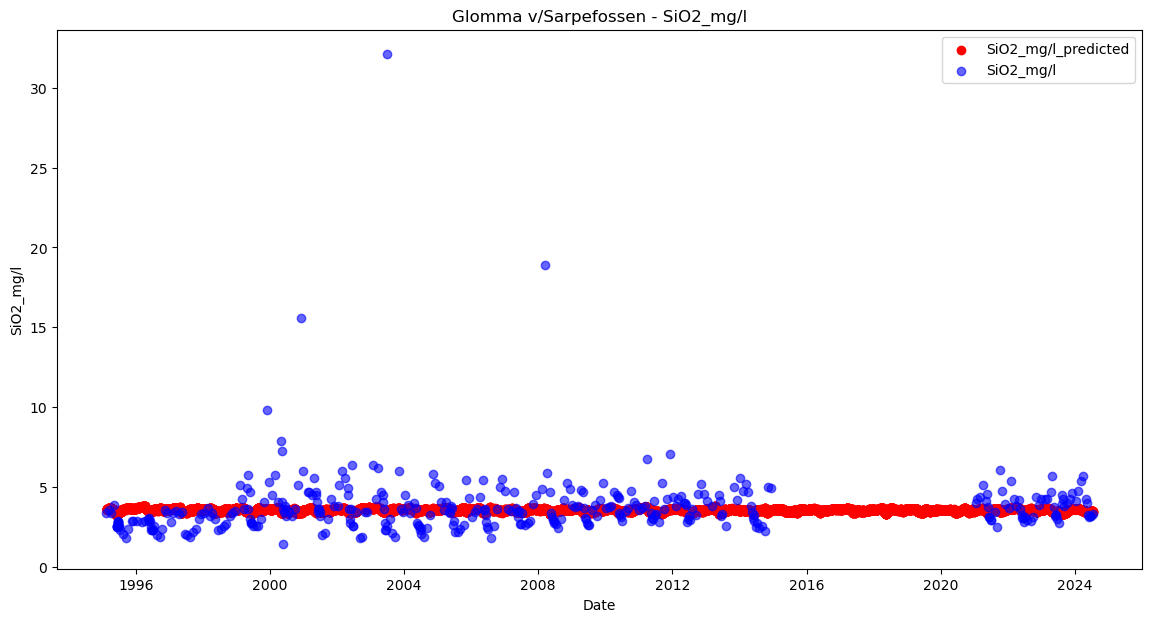

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Station: Glomma v/Sarpefossen, Variable: TOC_mg/l
Mean Absolute Error (MAE) on log-transformed data: 0.0959206981132914
Mean Squared Error (MSE) on log-transformed data: 0.013451892369871706
R-squared (R²) on log-transformed data: 0.08820320842382956


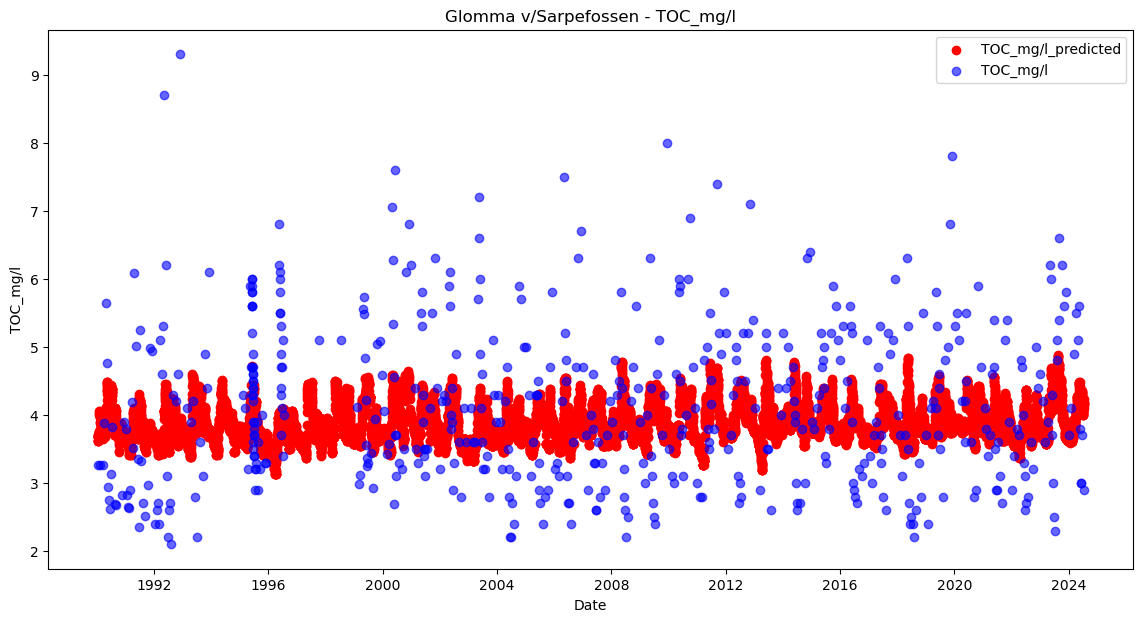

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Station: Glomma v/Sarpefossen, Variable: TOTN_µg/l
Mean Absolute Error (MAE) on log-transformed data: 0.09531689983432313
Mean Squared Error (MSE) on log-transformed data: 0.014427102701134946
R-squared (R²) on log-transformed data: 0.077380282778991


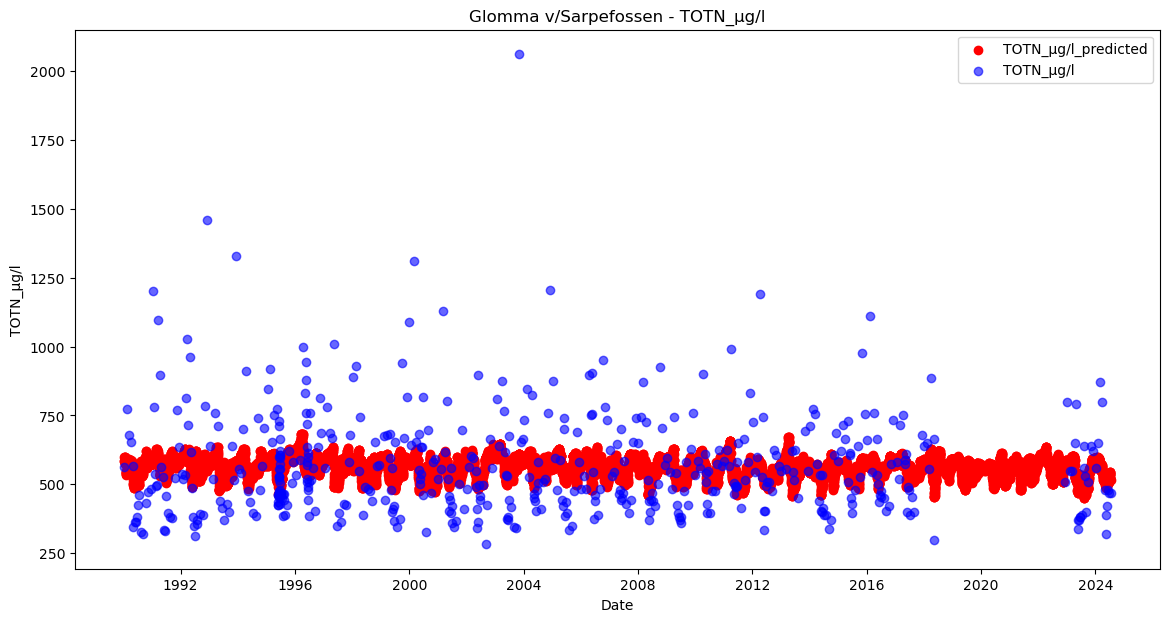

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Station: Glomma v/Sarpefossen, Variable: TOTP/F_µg/l P
Mean Absolute Error (MAE) on log-transformed data: 0.18814969588053773
Mean Squared Error (MSE) on log-transformed data: 0.05765516157786815
R-squared (R²) on log-transformed data: 0.008361206086744066


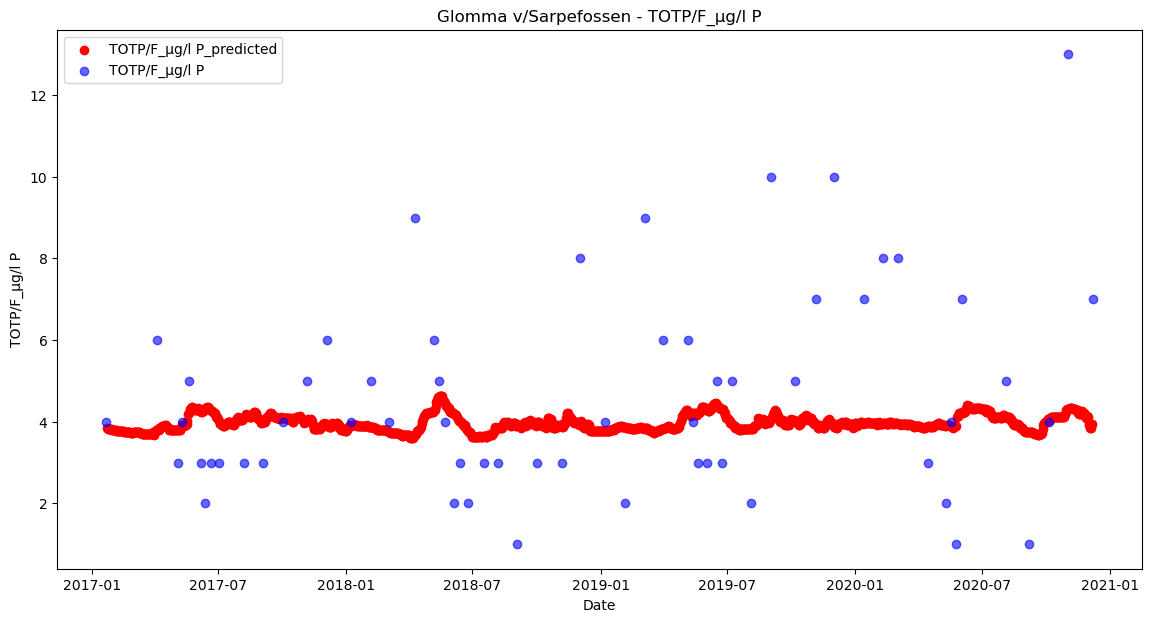

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Station: Glomma v/Sarpefossen, Variable: TOTP_P_µg/l P
Mean Absolute Error (MAE) on log-transformed data: 0.1539392480260054
Mean Squared Error (MSE) on log-transformed data: 0.04319411411590562
R-squared (R²) on log-transformed data: 0.06374459681085087


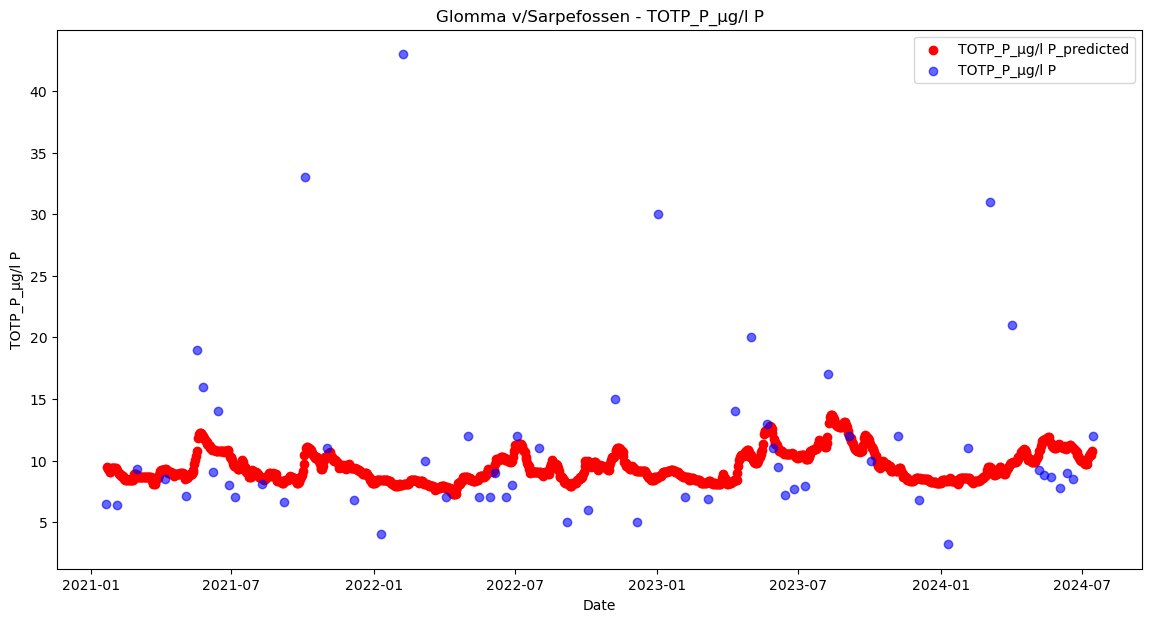

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Station: Glomma v/Sarpefossen, Variable: TSM_mg/l
Mean Absolute Error (MAE) on log-transformed data: 0.27951774289280257
Mean Squared Error (MSE) on log-transformed data: 0.13239485807329537
R-squared (R²) on log-transformed data: 0.1283329930399606


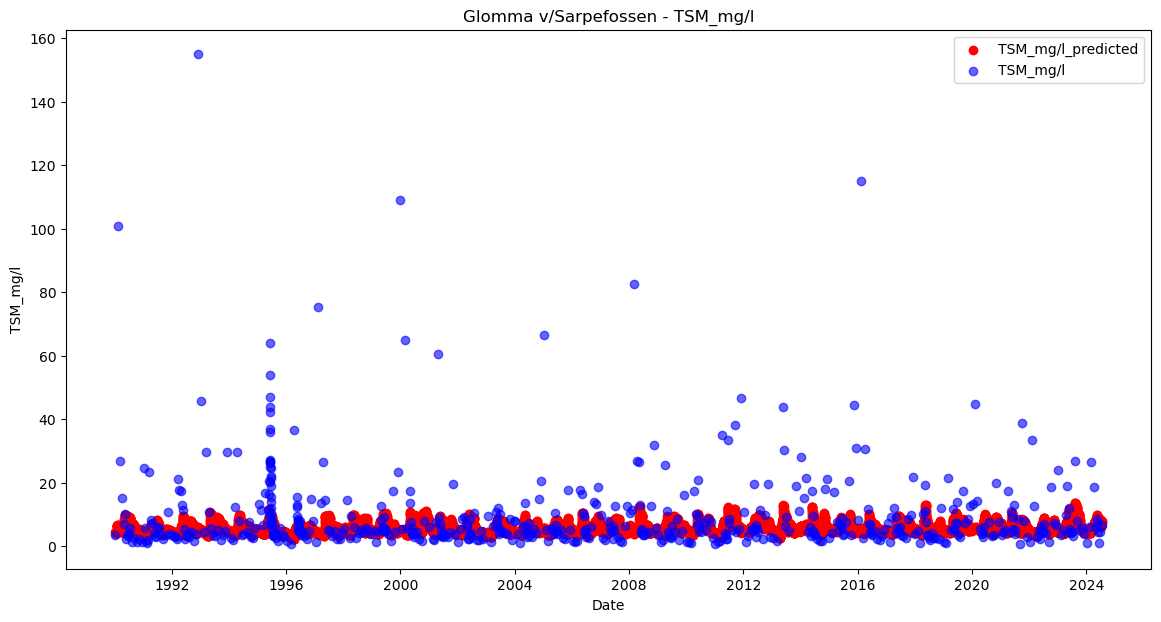

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Station: Drammenselva v/Krokstadelva, Variable: Farge_mg Pt/l
Mean Absolute Error (MAE) on log-transformed data: 0.06226325066168379
Mean Squared Error (MSE) on log-transformed data: 0.0066536321328950895
R-squared (R²) on log-transformed data: 0.4645919820124361


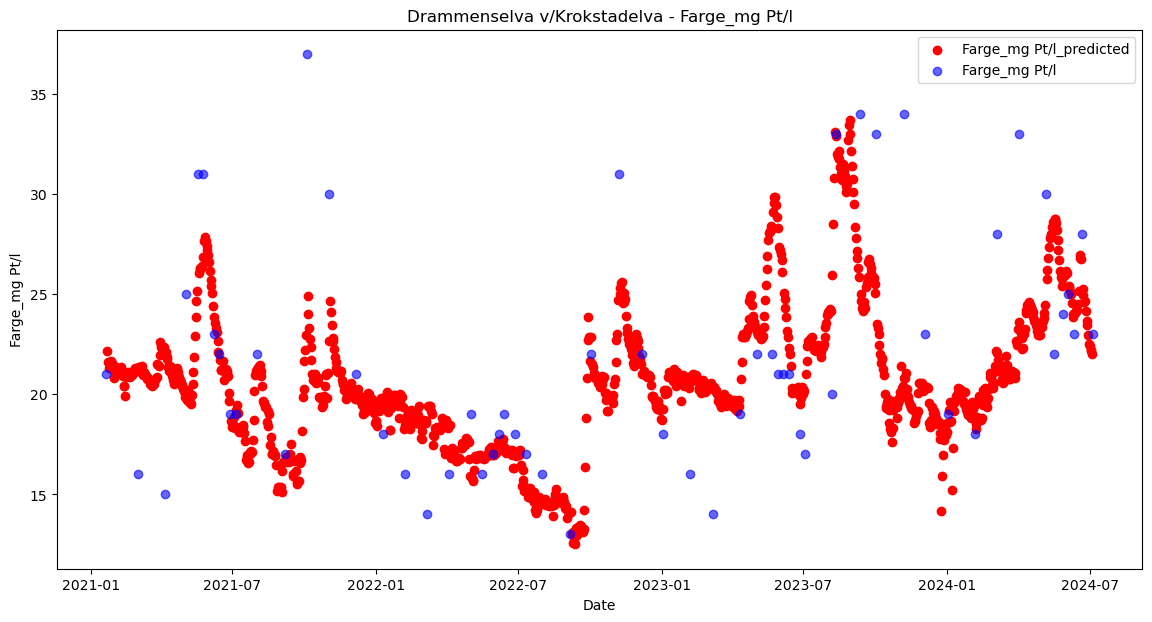

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Station: Drammenselva v/Krokstadelva, Variable: DIN_mg/l
Mean Absolute Error (MAE) on log-transformed data: 0.1087582024397323
Mean Squared Error (MSE) on log-transformed data: 0.02162402006767581
R-squared (R²) on log-transformed data: 0.020154511620155913


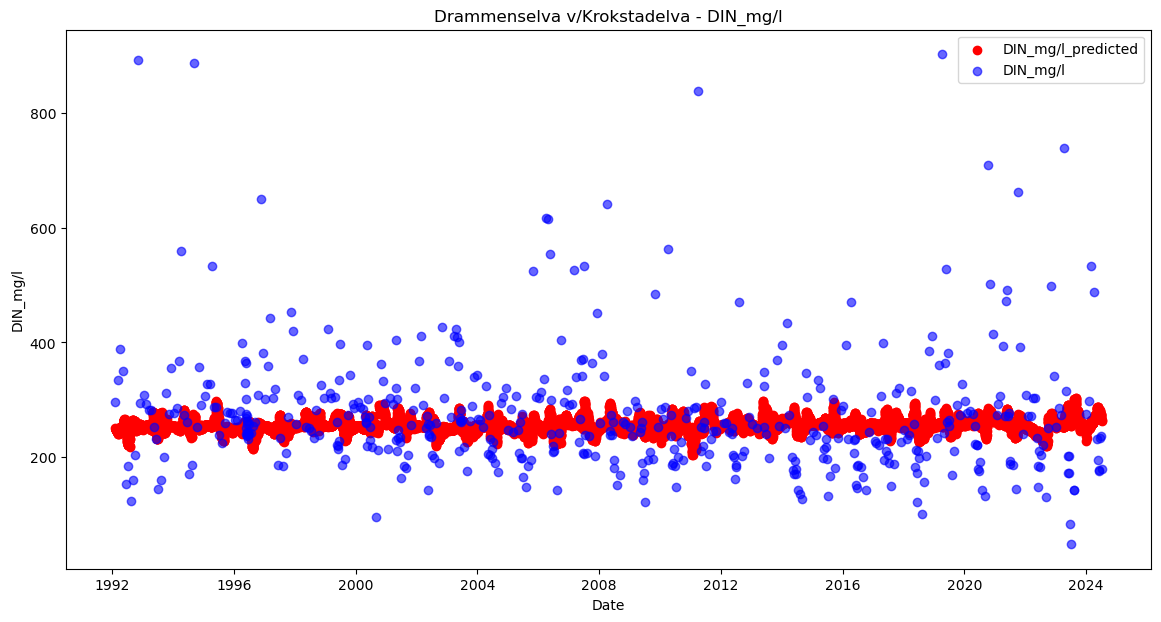

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Station: Drammenselva v/Krokstadelva, Variable: PO4-P_µg/l
Mean Absolute Error (MAE) on log-transformed data: 0.2257244907438927
Mean Squared Error (MSE) on log-transformed data: 0.08558299994550068
R-squared (R²) on log-transformed data: 0.17959875877891762


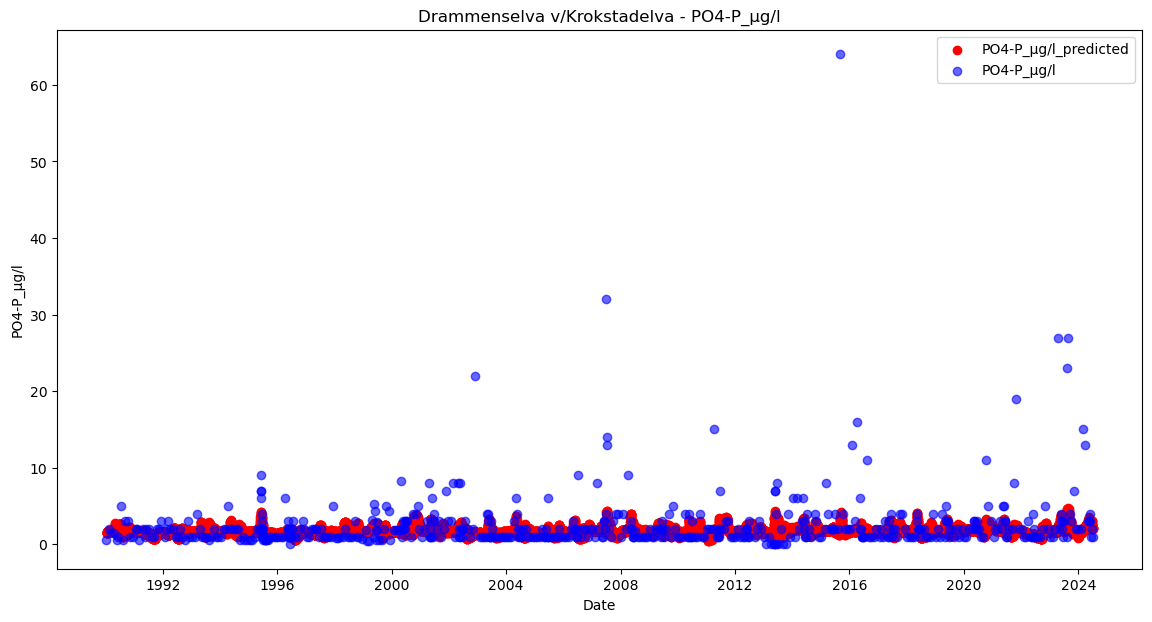

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Station: Drammenselva v/Krokstadelva, Variable: SiO2_mg/l
Mean Absolute Error (MAE) on log-transformed data: 0.052823201222170116
Mean Squared Error (MSE) on log-transformed data: 0.0052552260056068275
R-squared (R²) on log-transformed data: 0.19275134243756942


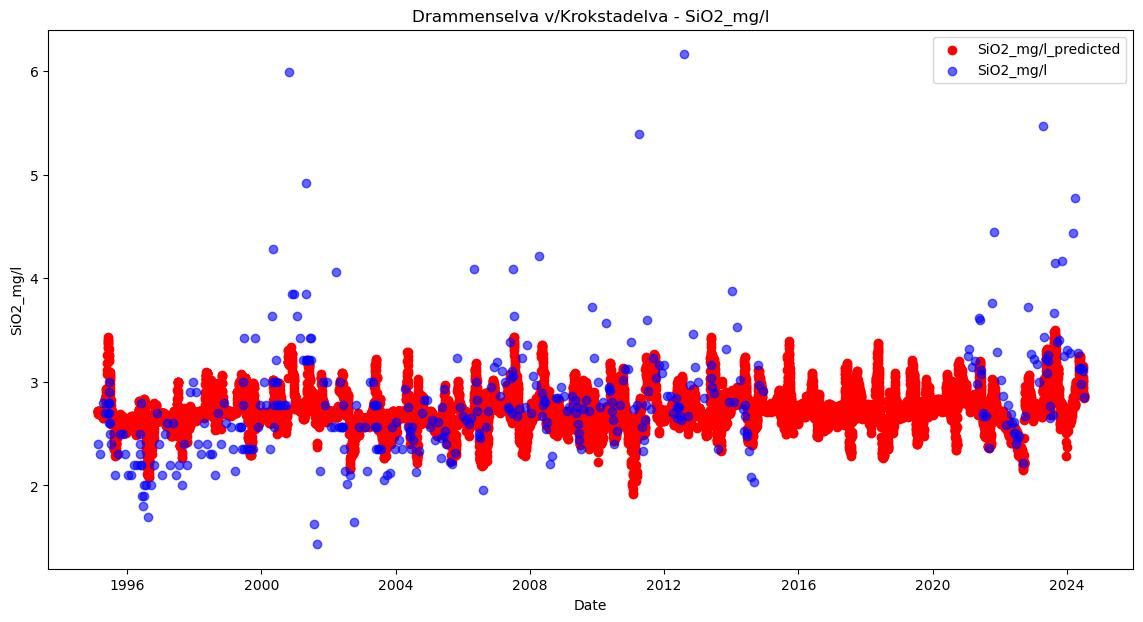

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Station: Drammenselva v/Krokstadelva, Variable: TOC_mg/l
Mean Absolute Error (MAE) on log-transformed data: 0.05607562982174454
Mean Squared Error (MSE) on log-transformed data: 0.005465715337238797
R-squared (R²) on log-transformed data: 0.20101034932271244


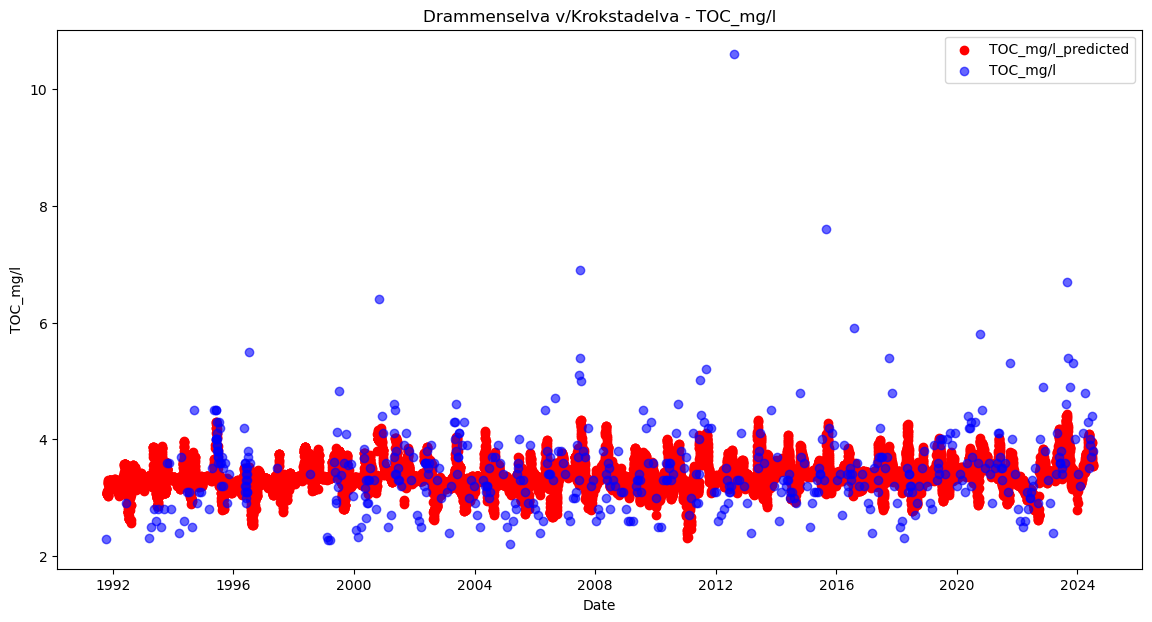

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Station: Drammenselva v/Krokstadelva, Variable: TOTN_µg/l
Mean Absolute Error (MAE) on log-transformed data: 0.06758079903473452
Mean Squared Error (MSE) on log-transformed data: 0.008970927693238042
R-squared (R²) on log-transformed data: 0.03499160675223956


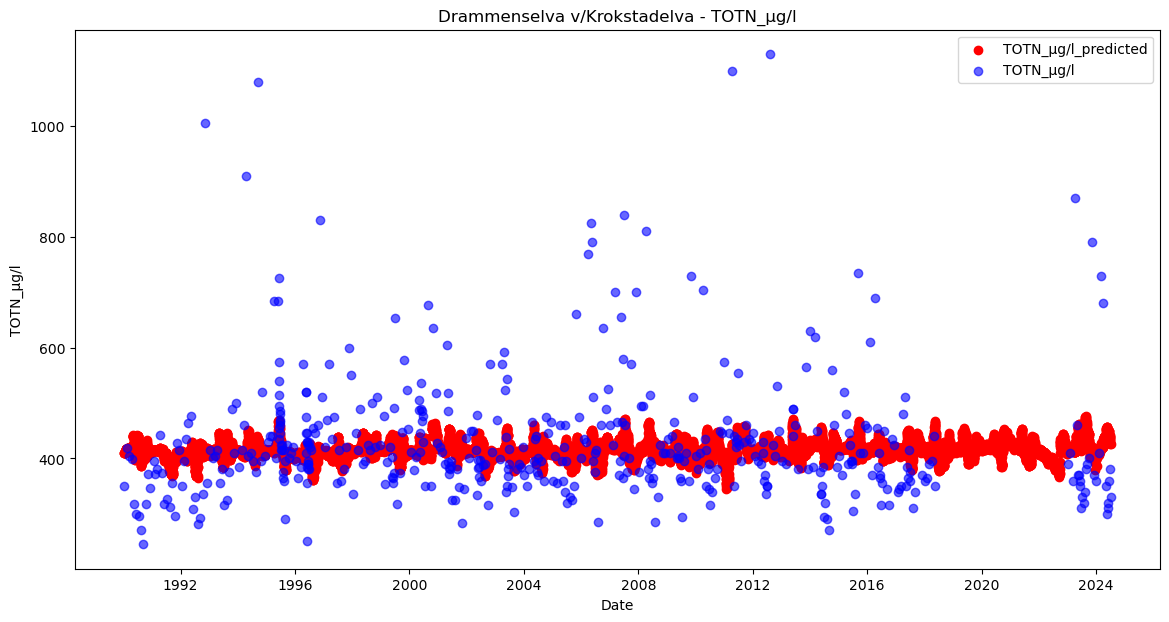

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Station: Drammenselva v/Krokstadelva, Variable: TOTP/F_µg/l P
Mean Absolute Error (MAE) on log-transformed data: 0.1144632631314027
Mean Squared Error (MSE) on log-transformed data: 0.029565924615054816
R-squared (R²) on log-transformed data: 0.029932084726936647


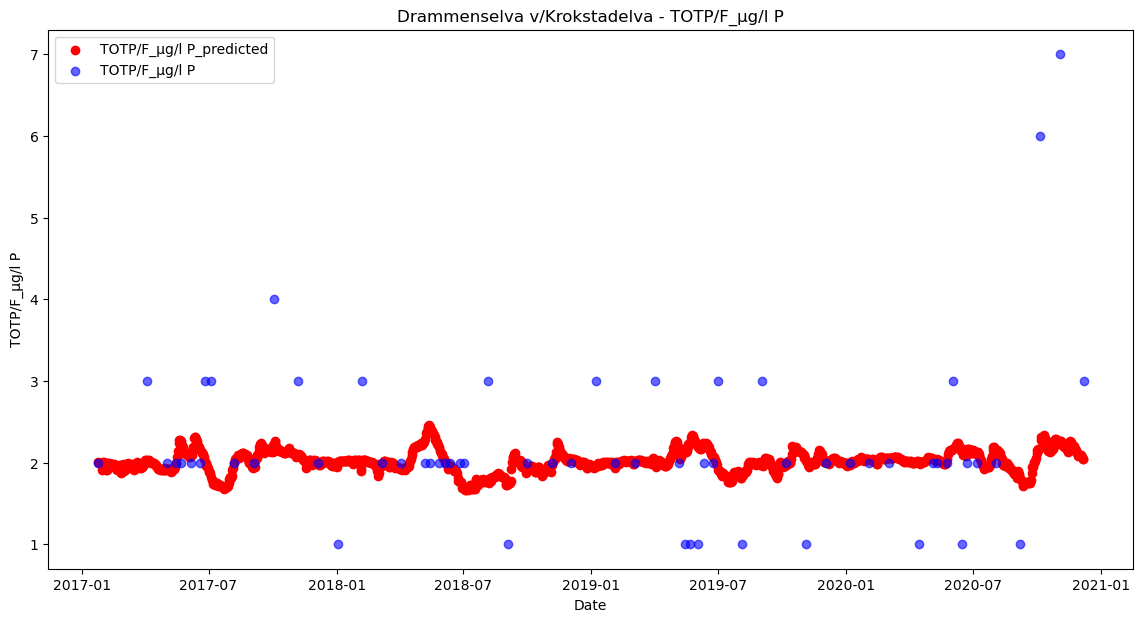

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Station: Drammenselva v/Krokstadelva, Variable: TOTP_P_µg/l P
Mean Absolute Error (MAE) on log-transformed data: 0.15239372917145413
Mean Squared Error (MSE) on log-transformed data: 0.04544741203556034
R-squared (R²) on log-transformed data: 0.16053022864585298


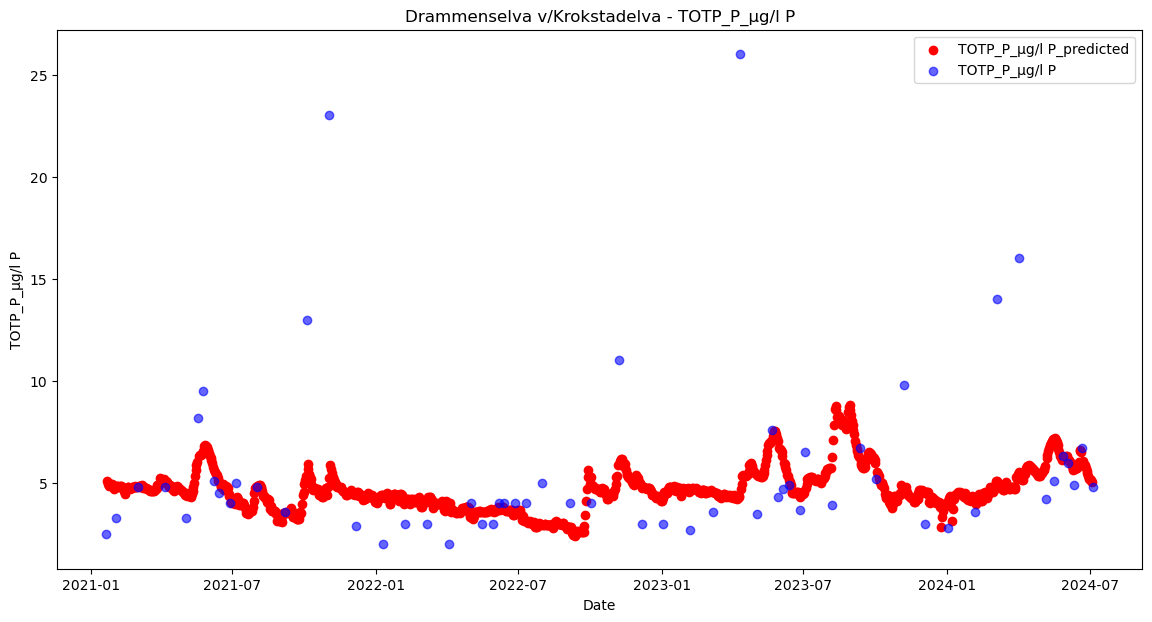

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Station: Drammenselva v/Krokstadelva, Variable: TSM_mg/l
Mean Absolute Error (MAE) on log-transformed data: 0.20619048130197182
Mean Squared Error (MSE) on log-transformed data: 0.07423660839906422
R-squared (R²) on log-transformed data: 0.26382773229668177


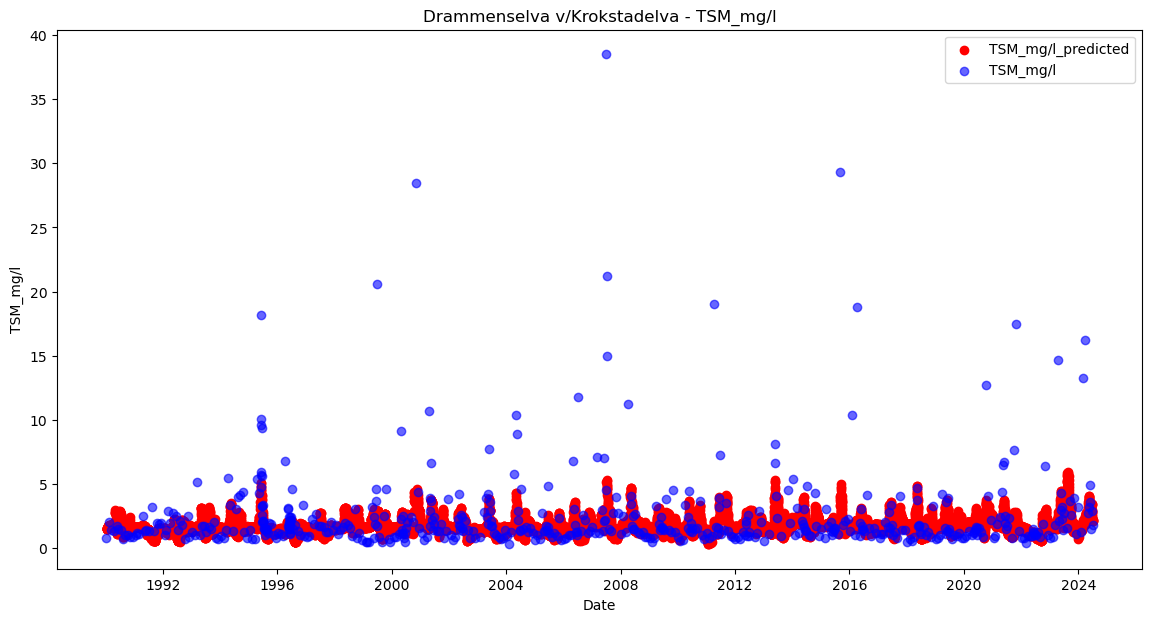

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Station: Numedalslågen v/E18, Variable: Farge_mg Pt/l
Mean Absolute Error (MAE) on log-transformed data: 0.11798113278866888
Mean Squared Error (MSE) on log-transformed data: 0.023032244787453287
R-squared (R²) on log-transformed data: 0.5192452064932129


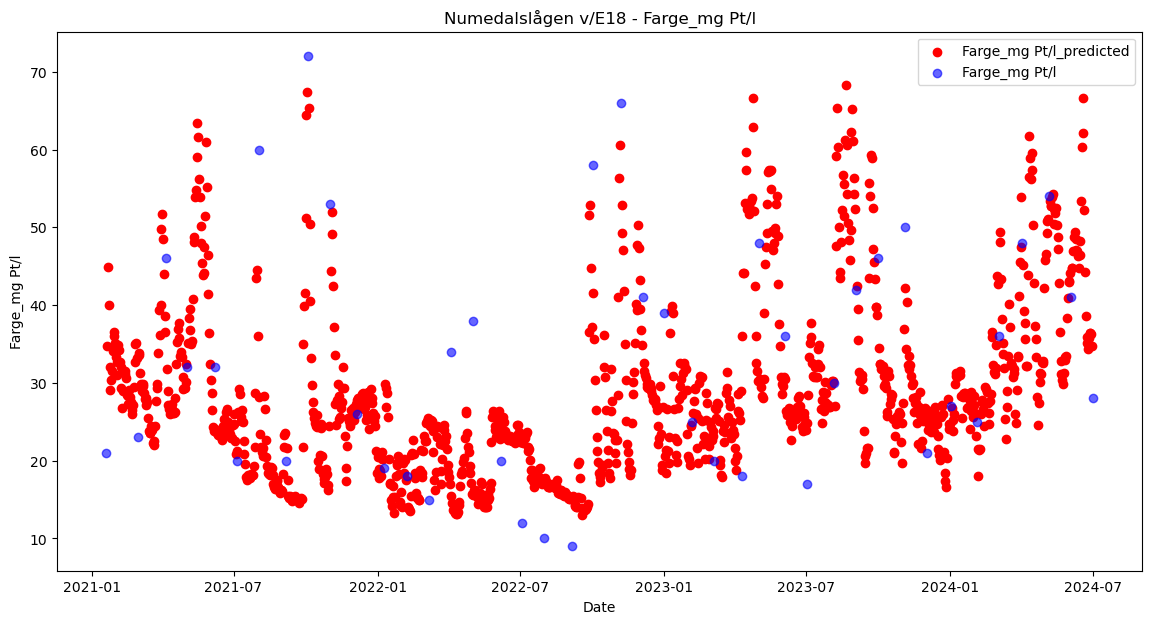

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Station: Numedalslågen v/E18, Variable: DIN_mg/l
Mean Absolute Error (MAE) on log-transformed data: 0.20872410687684814
Mean Squared Error (MSE) on log-transformed data: 0.0654647189988824
R-squared (R²) on log-transformed data: 0.00031616848026316813


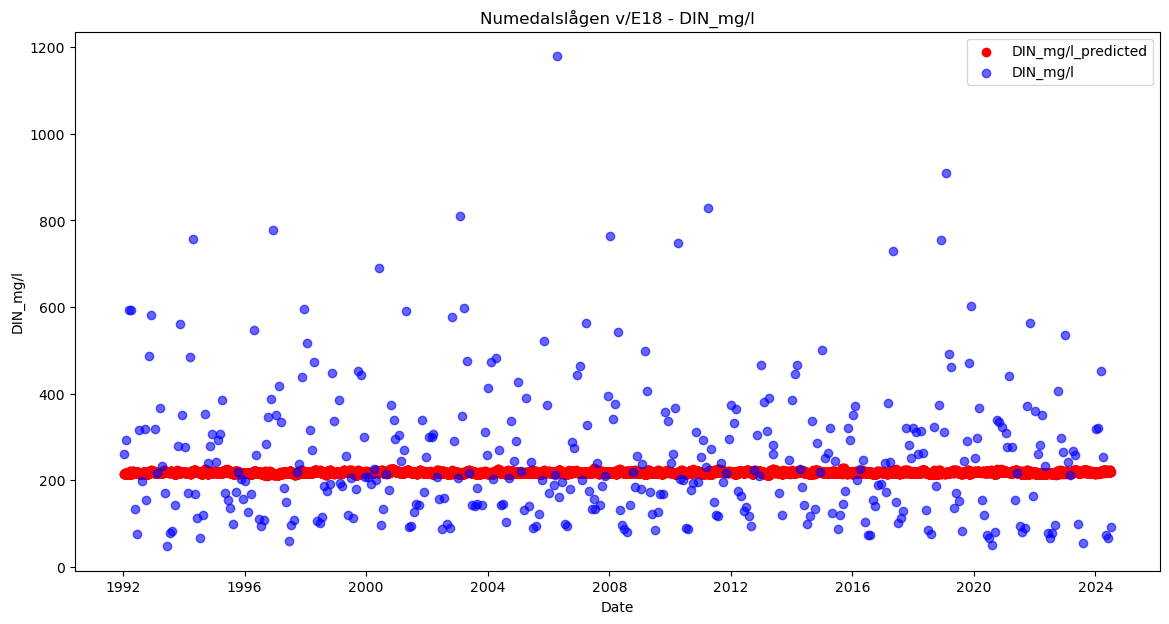

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Station: Numedalslågen v/E18, Variable: PO4-P_µg/l
Mean Absolute Error (MAE) on log-transformed data: 0.29157788436193266
Mean Squared Error (MSE) on log-transformed data: 0.13582868354449917
R-squared (R²) on log-transformed data: 0.1518556021150801


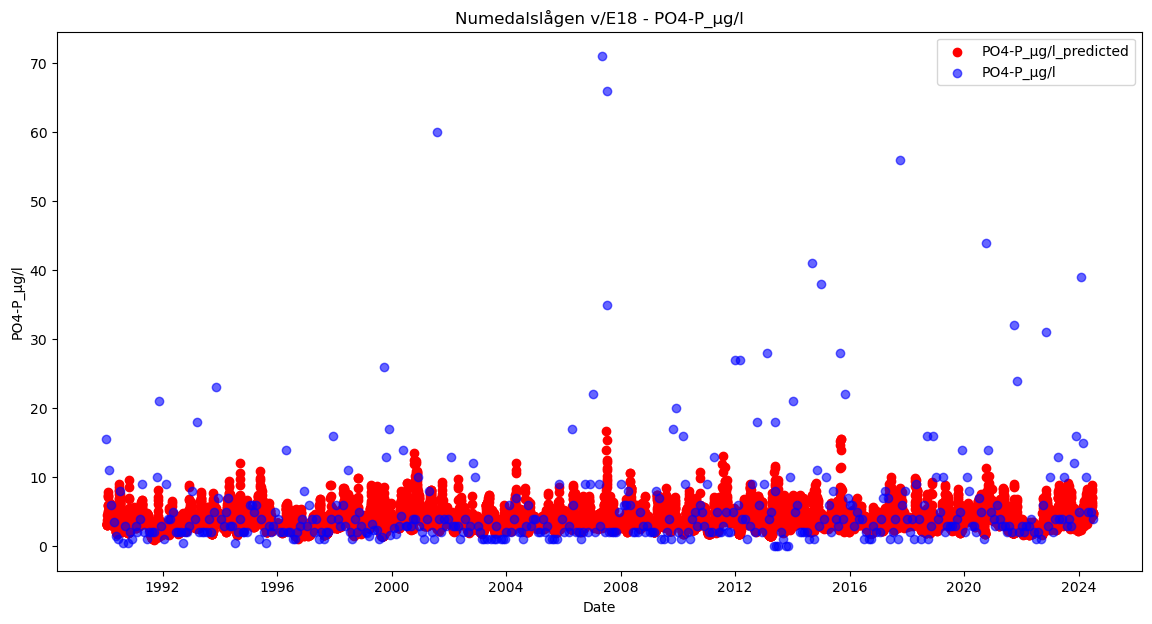

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Station: Numedalslågen v/E18, Variable: SiO2_mg/l
Mean Absolute Error (MAE) on log-transformed data: 0.10701966601999581
Mean Squared Error (MSE) on log-transformed data: 0.018024591935658134
R-squared (R²) on log-transformed data: 0.1398413028556197


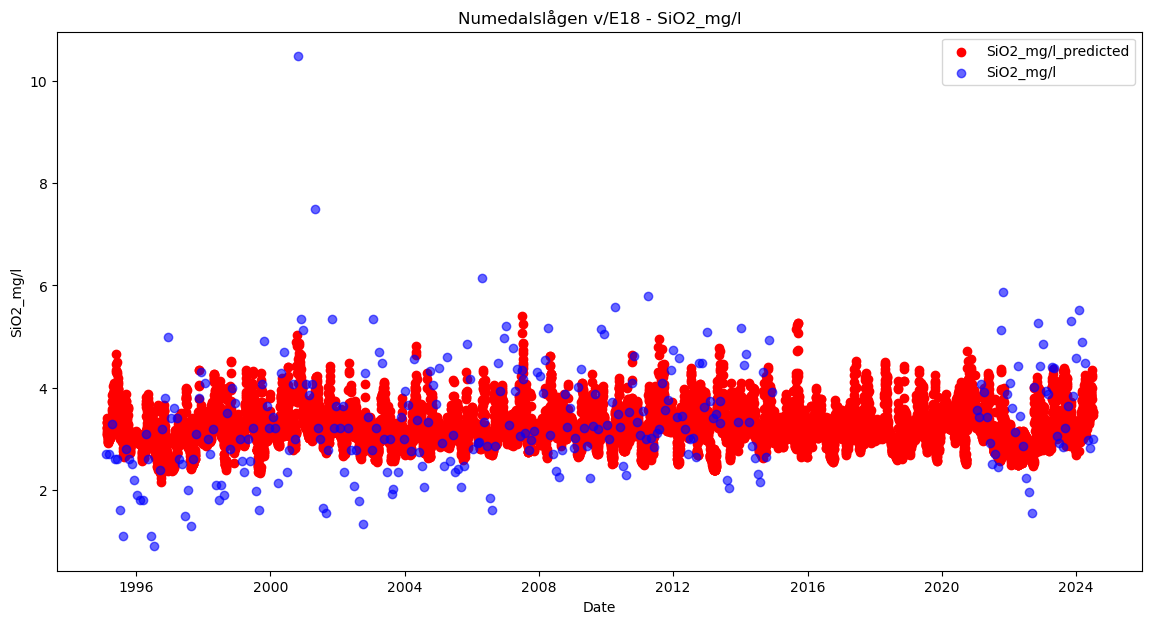

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Station: Numedalslågen v/E18, Variable: TOC_mg/l
Mean Absolute Error (MAE) on log-transformed data: 0.09732621701505992
Mean Squared Error (MSE) on log-transformed data: 0.015555324342301398
R-squared (R²) on log-transformed data: 0.3904660715448547


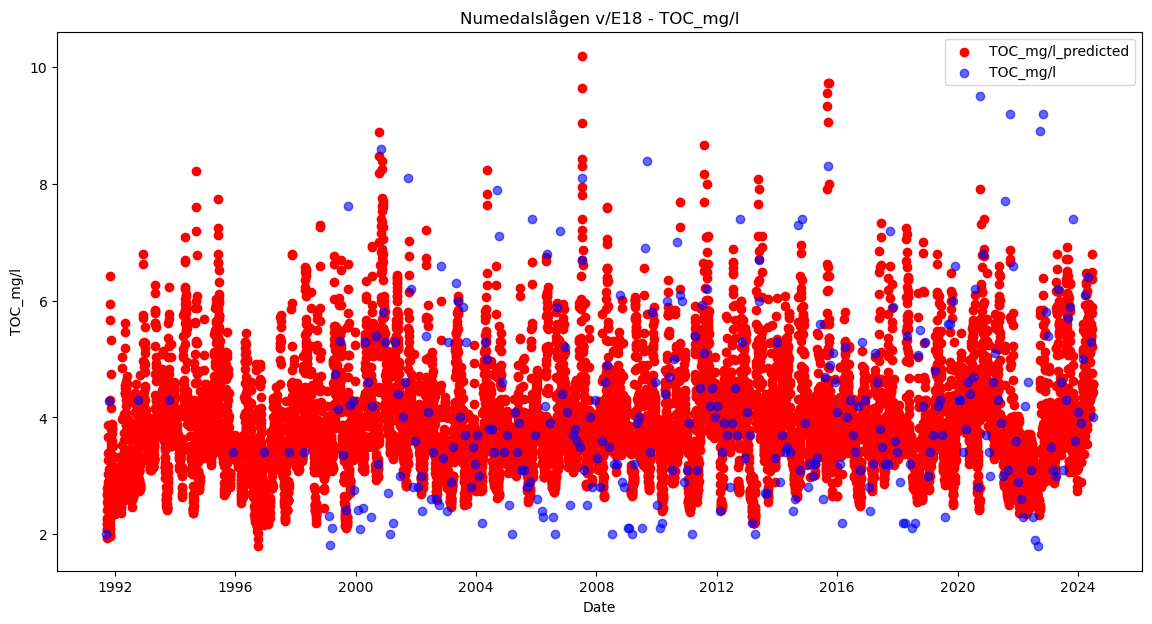

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Station: Numedalslågen v/E18, Variable: TOTN_µg/l
Mean Absolute Error (MAE) on log-transformed data: 0.13738733368595477
Mean Squared Error (MSE) on log-transformed data: 0.028532071460146042
R-squared (R²) on log-transformed data: 0.010044597618073303


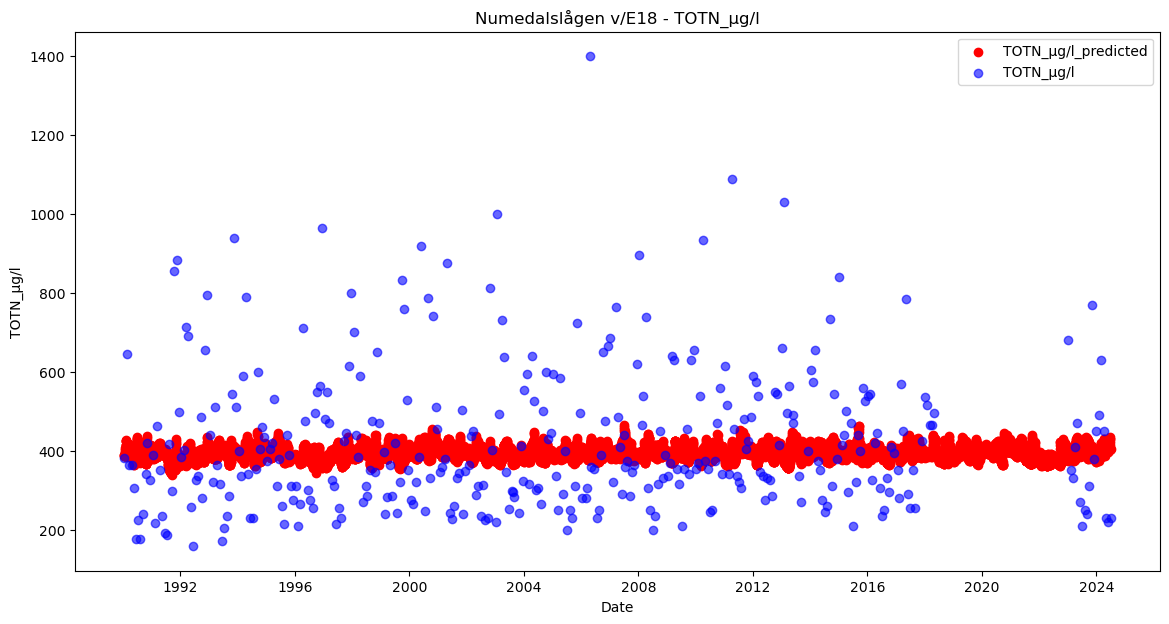

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Station: Numedalslågen v/E18, Variable: TOTP/F_µg/l P
Mean Absolute Error (MAE) on log-transformed data: 0.15407749778310573
Mean Squared Error (MSE) on log-transformed data: 0.03836981603613072
R-squared (R²) on log-transformed data: 0.17323100204432962


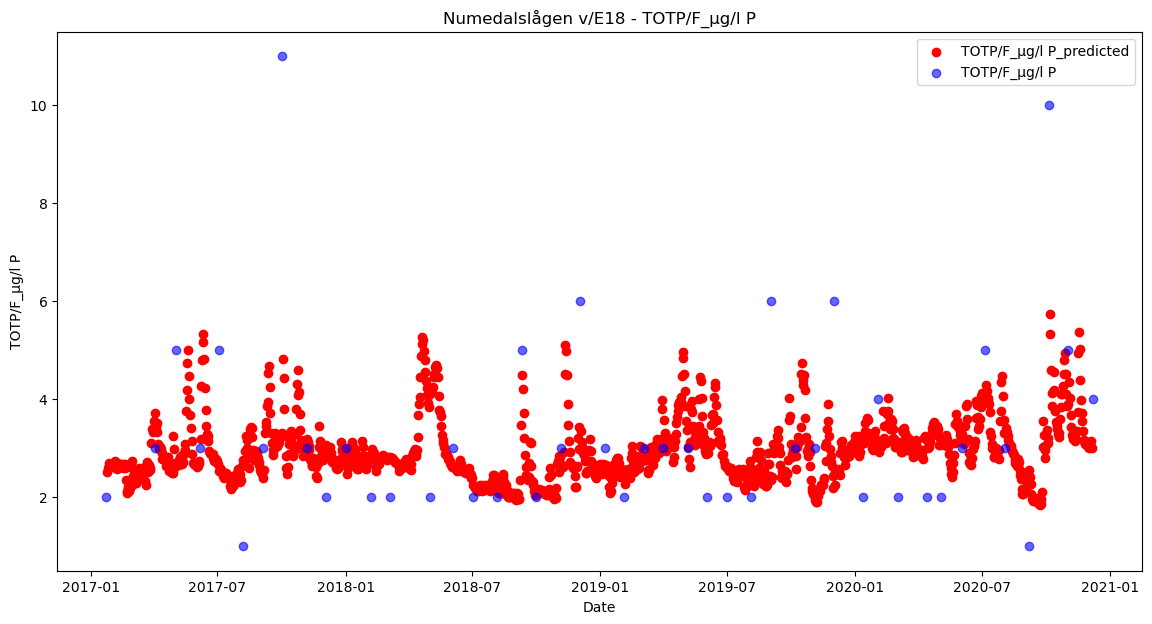

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Station: Numedalslågen v/E18, Variable: TOTP_P_µg/l P
Mean Absolute Error (MAE) on log-transformed data: 0.18008645423110983
Mean Squared Error (MSE) on log-transformed data: 0.053882666009523086
R-squared (R²) on log-transformed data: 0.3357992764195853


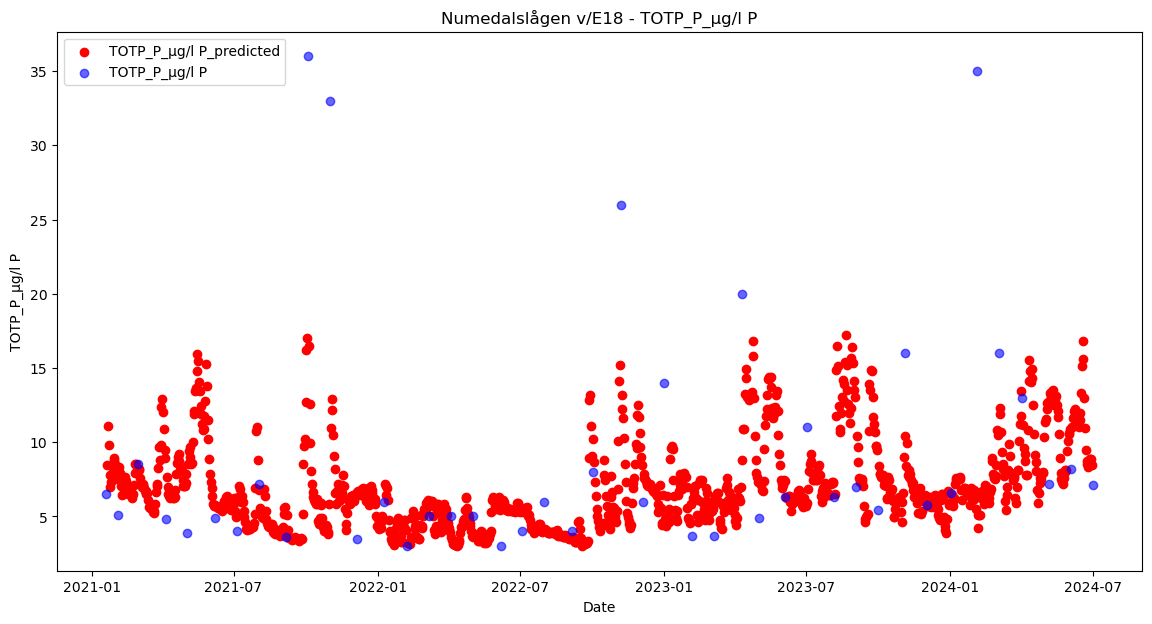

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Station: Numedalslågen v/E18, Variable: TSM_mg/l
Mean Absolute Error (MAE) on log-transformed data: 0.2600810450972291
Mean Squared Error (MSE) on log-transformed data: 0.10808223060871841
R-squared (R²) on log-transformed data: 0.3069598565553492


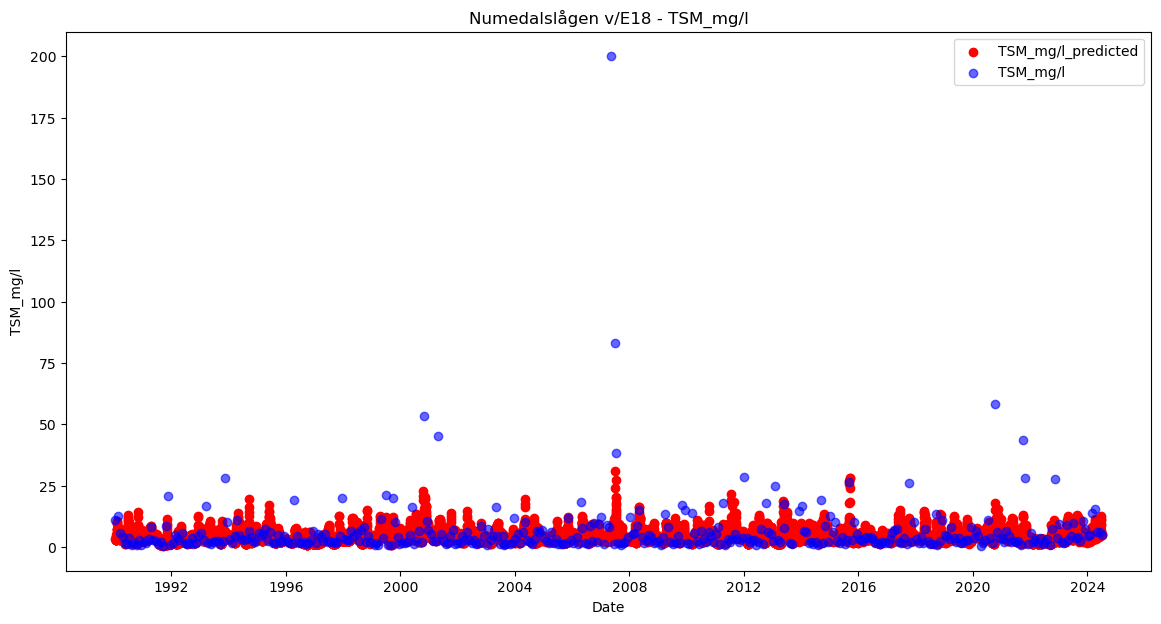

In [15]:
interpolated_df = pd.DataFrame()

# Process each station and variable separately
stations = merged_df['station_name'].unique()

for station in stations:
    station_df = merged_df[merged_df['station_name'] == station].copy()
    
    # Remove duplicates, keeping only the first occurrence for each date and station_name combination
    station_df.drop_duplicates(subset=['Date', 'station_name'], keep='first', inplace=True)
    
    for var in variables:
        if var in station_df.columns:
            # Separate the data into two variables: the current variable and discharge
            y = station_df[var]
            X = station_df[['discharge']]
            
            # Identify the rows with missing values for the current variable
            missing_indices = y[y.isna()].index
            
            # Prepare the data for linear regression
            train_df = station_df.dropna(subset=[var]).copy()
            
            # Apply log base 10 transformation to the data, handling divide by zero by replacing zeros with a small value
            train_df[f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
            train_df['log_discharge'] = np.log10(train_df['discharge'].replace(0, np.nan)).fillna(0)
            
            # Train the linear regression model on log-transformed data
            X_train_log = train_df[['log_discharge']]
            y_train_log = train_df[f'log_{var}']
            model_log = LinearRegression()
            model_log.fit(X_train_log, y_train_log)
            
            # Predict the missing values using the trained model on log-transformed data
            X_missing_log = np.log10(station_df.loc[missing_indices, 'discharge'].replace(0, np.nan)).fillna(0).values.reshape(-1, 1)
            if len(X_missing_log) > 0:  # Ensure there are missing values to predict
                predicted_log_toc = model_log.predict(X_missing_log)
                
                # Convert predictions back to original scale
                predicted_toc = np.power(10, predicted_log_toc)
                
                # Add the new predicted timeseries to the filtered dataframe in a separate column
                station_df.loc[missing_indices, f'{var}_predicted'] = predicted_toc
                
                # Append the interpolated values to the main DataFrame
                interpolated_df = pd.concat([interpolated_df, station_df], ignore_index=True)
                
            # Evaluate the model on log-transformed data
            y_train_pred_log = model_log.predict(X_train_log)
            
            mae_log = mean_absolute_error(y_train_log, y_train_pred_log)
            mse_log = mean_squared_error(y_train_log, y_train_pred_log)
            r2_log = r2_score(y_train_log, y_train_pred_log)
            
            print(f'Station: {station}, Variable: {var}')
            print(f'Mean Absolute Error (MAE) on log-transformed data: {mae_log}')
            print(f'Mean Squared Error (MSE) on log-transformed data: {mse_log}')
            print(f'R-squared (R²) on log-transformed data: {r2_log}')
            
            # Produce scatter plots for each variable at each station separately
            plt.figure(figsize=(14, 7))
            
            # Filter data to only include dates between first and last available measurement for the variable
            first_date = station_df[var].first_valid_index()
            last_date = station_df[var].last_valid_index()
            
            filtered_station_df = station_df.loc[first_date:last_date]
            
            plt.scatter(filtered_station_df['Date'], filtered_station_df[f'{var}_predicted'], label=f'{var}_predicted', color='red')
            plt.scatter(filtered_station_df['Date'], filtered_station_df[var], label=var, color='blue', alpha=0.6)
            plt.xlabel('Date')
            plt.ylabel(var)
            plt.title(f'{station} - {var}')
            plt.legend()
            plt.show()